In [1]:
import os
import json
import glob
import copy
import copy
import itertools
import pprint 
pp = pprint.PrettyPrinter(indent=4)

import numpy as np
import pylab as pl
import seaborn as sns
import pandas as pd
import statsmodels as sm
import cPickle as pkl

from scipy import stats as spstats

from pipeline.python.classifications import experiment_classes as util
from pipeline.python.classifications import aggregate_data_stats as aggr
from pipeline.python.classifications import rf_utils as rfutils
from pipeline.python.retinotopy import utils as retutils
from pipeline.python.retinotopy import segment_retinotopy as seg

from pipeline.python import utils as putils

from matplotlib.lines import Line2D
import matplotlib.patches as patches

from pipeline.python.classifications import decode_utils as dutils
from pipeline.python.classifications import decode_by_ncells as dc
from pipeline.python.classifications import decode_utils as decutils

%matplotlib notebook

In [2]:
responsive_test='ROC'
responsive_thr=10. if responsive_test=='nstds' else 0.05
experiment='blobs'

traceid = 'traces001'
fov_type = 'zoom2p0x'
state = 'awake'
rootdir = '/n/coxfs01/2p-data'
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
stats_dir = os.path.join(aggregate_dir, 'data-stats')

In [3]:
# Set colors
visual_areas, area_colors = putils.set_threecolor_palette(soft=True)
dpi = putils.set_plot_params()

In [4]:
# Get all data sets
visual_areas = ['V1', 'Lm', 'Li']
sdata = aggr.get_aggregate_info(traceid=traceid, fov_type=fov_type, state=state)
sdata['visual_area'].unique()

Segmentation: missing 9 dsets


array([u'Li', u'Ll', u'Lm', u'V1'], dtype=object)

In [5]:
print("............................................")
print("Responsive test: %s (thr=%.2f)" % (responsive_test, responsive_thr))
print("............................................")

curr_visual_area=None #'V1'
curr_datakey = None# '20190617_JC097_fov1'

#### Load neural responses
analysis_type='by_fov'
trial_epoch='plushalf'
response_type='dff'

stack_neuraldf = False

#### Check for equal trial counts
sdata, all_cells, MEANS, SDF = aggr.get_source_data(experiment,
                        equalize_now=False, zscore_now=False,
                        response_type=response_type, responsive_test=responsive_test,
                        responsive_thr=responsive_thr, trial_epoch=trial_epoch,
                        visual_area=curr_visual_area, datakey=curr_datakey,
                        check_configs=True, return_configs=True, return_missing=False,
                        images_only=False)

all_cells = all_cells[all_cells['visual_area'].isin(visual_areas)]
all_cells.groupby(['visual_area']).count()

............................................
Responsive test: ROC (thr=0.05)
............................................
Segmentation: missing 9 dsets
...loading: /n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_blobs_trialmeans_traces001_ROC-thr-0.05_dff_plushalf.pkl
*Warning* <20190314_JC070_fov1> More than 1 pos? x: [-15   0], y: [-5  0]
(skipping 20190314_JC070_fov1)
Segmentation: missing 9 dsets
SDF, images_only=False (excluding dsetes: [])


cell   fov  animalid  session  datakey  fovnum  global_ix
visual_area                                                           
Li            585   585       585      585      585     585        585
Lm           1127  1127      1127     1127     1127    1127       1127
V1           1251  1251      1251     1251     1251    1251       1251

In [6]:
overlap_thr=None
has_retino=False
threshold_dff=False
threshold_snr=False
match_distns = False
remove_too_few=False
min_ncells=5


#### Responsive params
n_stds = None if responsive_test=='ROC' else 2.5 #None
response_str = '%s_%s-thr-%.2f' % (response_type, responsive_test, responsive_thr) 


stack_neuraldf = True
NDATA, CELLS = dc.get_cells_and_data(all_cells, MEANS, traceid=traceid, response_type=response_type, 
                stack_neuraldf=True, overlap_thr=overlap_thr, has_retino=has_retino, 
                threshold_snr=threshold_snr, remove_too_few=remove_too_few, min_ncells=min_ncells,
                threshold_dff=threshold_dff) 
                                
print("------------------------------------")
print("Final cell counts:")
CELLS[['visual_area', 'datakey', 'cell']].drop_duplicates().groupby(['visual_area']).count()

cell_counts = dict(CELLS.groupby(['visual_area'])['cell'].count())

print("@@@@@@@@ cell counts @@@@@@@@@@@")
print(cell_counts)
print("Max/min (%s): %.2f, %.2f" % (response_type, NDATA['response'].max(), NDATA['response'].min()))

~~~~~~~~~~~~~~~~No Receptive Fields~~~~~~~~~~~~~~~~~~~~~~~~~
Assigned visual areas: [u'Li' u'Lm' u'V1']
@@@@@@@@ cell counts @@@@@@@@@@@
{u'V1': 1251, u'Lm': 1127, u'Li': 585}
------------------------------------
------------------------------------
Final cell counts:
@@@@@@@@ cell counts @@@@@@@@@@@
{u'V1': 1251, u'Lm': 1127, u'Li': 585}
Max/min (dff): 4.97, -0.56


In [7]:
data_id = '%s_%s_%s' % (traceid, response_str, trial_epoch)
data_id

'traces001_dff_ROC-thr-0.05_plushalf'

# Stdev?

In [8]:
x0 = NDATA[(NDATA.visual_area==visual_area) & (NDATA.datakey==datakey)].copy()
m = x0.groupby(['cell', 'config']).mean().reset_index()


n2 = aggr.stacked_neuraldf_to_unstacked(m)
n2.shape
n3 = n2.drop('config', axis=1).divide(n2.drop('config', axis=1).sum(axis=0), axis=1)
n3['config'] = n2['config'].values
ndf = aggr.unstacked_neuraldf_to_stacked(n3)

sz_df = pd.concat([pd.Series(ndf[ndf.config.isin(sg.index.tolist())].groupby(['cell']).mean()['response'], name=sz)\
            for sz, sg in sdf[sdf.morphlevel!=-1].groupby(['size'])], axis=1)

mp_df = pd.concat([pd.Series(ndf[ndf.config.isin(sg.index.tolist())].groupby(['cell']).mean()['response'], name=sz)\
            for sz, sg in sdf[sdf.morphlevel!=-1].groupby(['morphlevel'])], axis=1)


NameError: name 'visual_area' is not defined

In [ ]:
fig, axn = pl.subplots(1,2, figsize=(8,4), sharey=True)
sns.heatmap(sz_df, ax=axn[0])
axn[0].set_title('size')

sns.heatmap(mp_df, ax=axn[1])
axn[1].set_title('morphlevel')

fig.text(0.05, 0.95, '%s (%s)' % (datakey, visual_area))

In [139]:
reload(aggr)

<module 'pipeline.python.classifications.aggregate_data_stats' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/aggregate_data_stats.py'>

In [189]:
t_=[]
for (visual_area, datakey), x0 in NDATA.groupby(['visual_area', 'datakey']):

    sdf = SDF[datakey].copy()
    #ndf = x0.copy()    
    m = x0.groupby(['cell', 'config']).mean().reset_index()
    n2 = aggr.stacked_neuraldf_to_unstacked(m)
    n3 = n2.drop('config', axis=1).divide(n2.drop('config', axis=1).sum(axis=0), axis=1)
    n3['config'] = n2['config'].values
    ndf = aggr.unstacked_neuraldf_to_stacked(n3)

#     rois_ = [r for r in x1.columns if putils.isnumber(r)]
#     x2 = x1[rois_].subtract(x1[rois_].min(axis=0))
#     x2['config'] = x1['config']
#     x2['trial'] = x2.index.tolist()
#     ndf = pd.melt(x2, id_vars=['config', 'trial'], var_name='cell', value_name='response')

    sz_df = pd.concat([pd.Series(ndf[ndf.config.isin(sg.index.tolist())].groupby(['cell']).mean()['response'], name=sz)\
                for sz, sg in sdf[sdf.morphlevel!=-1].groupby(['size'])], axis=1)

    mp_df = pd.concat([pd.Series(ndf[ndf.config.isin(sg.index.tolist())].groupby(['cell']).mean()['response'], name=sz)\
                for sz, sg in sdf[sdf.morphlevel!=-1].groupby(['morphlevel'])], axis=1)

    sz1 = sz_df.copy() #sz_df.divide(sz_df.sum(axis=1), axis=0)
    mp1 = mp_df.copy() #mp_df.divide(mp_df.sum(axis=1), axis=0)

    stds_sz = pd.DataFrame(sz1.std(axis=1), columns=['std'])
    stds_sz['condition'] = 'size'

    stds_mp = pd.DataFrame(mp1.std(axis=1), columns=['std'])
    stds_mp['condition'] = 'morphlevel'

    tmpdf = pd.concat([stds_sz, stds_mp], axis=0)
    tmpdf['cell'] = tmpdf.index.tolist()
    tmpdf['visual_area'] = visual_area
    tmpdf['datakey']=datakey
    
    t_.append(tmpdf)

In [190]:
df = pd.concat(t_, axis=0)
df.head()

std condition  cell visual_area              datakey
cell                                                           
174   0.000041      size   174          Li  20190314_JC070_fov1
175   0.000028      size   175          Li  20190314_JC070_fov1
177   0.000059      size   177          Li  20190314_JC070_fov1
219   0.000023      size   219          Li  20190314_JC070_fov1
220   0.000017      size   220          Li  20190314_JC070_fov1

#### plot fits

<IPython.core.display.Javascript object>


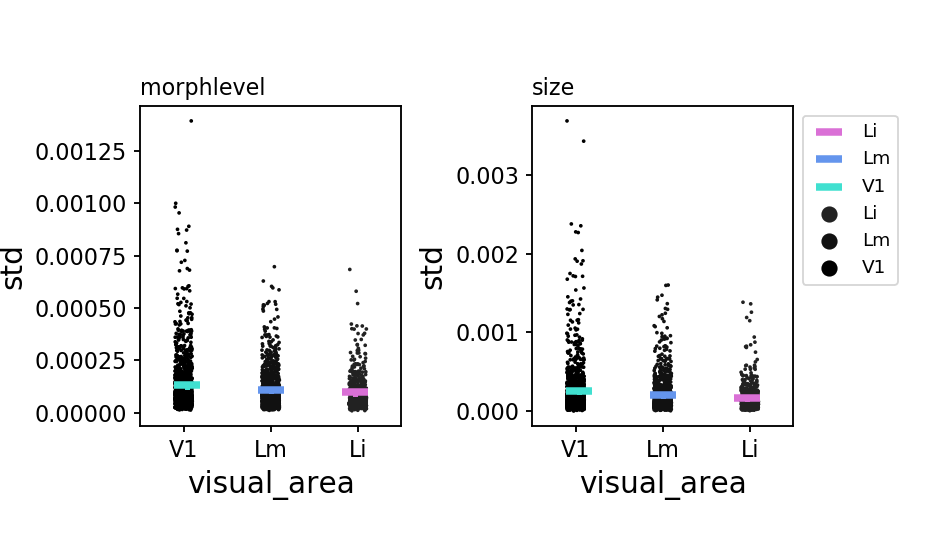

In [191]:

fig, axn = pl.subplots(1,2, figsize=(7,4))
    
for ai, (ax, (cond, mg)) in enumerate(zip(axn.flat, df.groupby(['condition']))):
    
    sns.pointplot(x='visual_area', y='std', data=mg, ax=ax, 
             hue='visual_area', palette=area_colors, order=visual_areas, scale=2,
                  markers='_', dodge=True, join=False)
    
    sns.stripplot(x='visual_area', y='std', data=mg, ax=ax, 
             hue='visual_area', color='k', order=visual_areas, size=2, zorder=-1)

    if ai==0:
        ax.legend_.remove()
    else:
        ax.legend(bbox_to_anchor=(1., 1), loc='upper left')
    ax.set_title(cond, loc='left')

pl.subplots_adjust(left=0.15, right=0.85, bottom=0.2, top=0.8, wspace=0.5)

#### means by fov

<IPython.core.display.Javascript object>


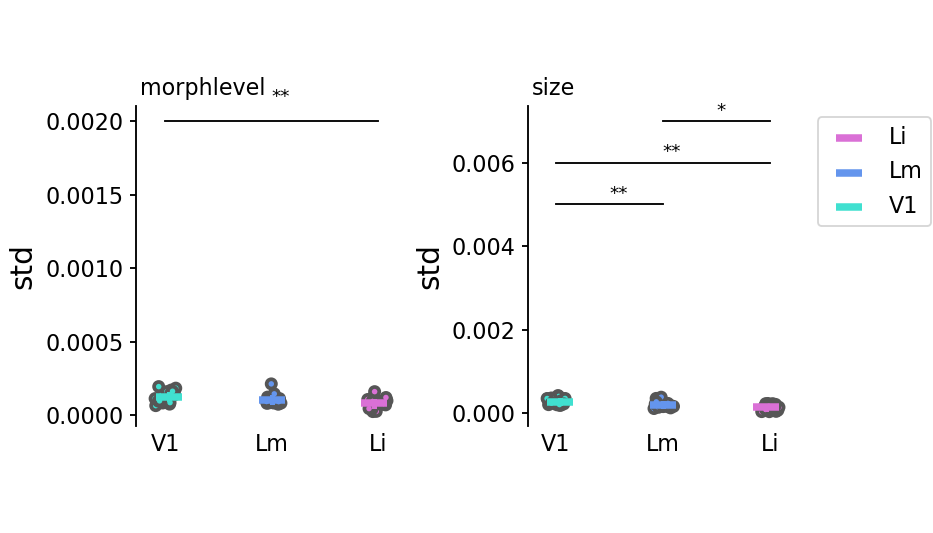

********* [std] Mann-Whitney U test(mc=fdr_bh) **********
[('V1', 'Lm')] p=0.060 (fdr_bh), reject H0=False
[('V1', 'Li')] p=0.009 (fdr_bh), reject H0=True
[('Lm', 'Li')] p=0.091 (fdr_bh), reject H0=False
****************************
********* [std] Mann-Whitney U test(mc=fdr_bh) **********
[('V1', 'Lm')] p=0.005 (fdr_bh), reject H0=True
[('V1', 'Li')] p=0.000 (fdr_bh), reject H0=True
[('Lm', 'Li')] p=0.013 (fdr_bh), reject H0=True
****************************


In [192]:
multi_comp_test='fdr_bh'

means_by_fov = df.groupby(['visual_area', 'datakey', 'condition' ]).mean().reset_index()

fig, axn = pl.subplots(1,2, figsize=(7,4))
for ai, (ax, (cond, mg)) in enumerate(zip(axn.flat, means_by_fov.groupby(['condition']))):
    
    sns.pointplot(x='visual_area', y='std', data=mg[mg.condition==cond], ax=ax, 
             hue='visual_area', palette=area_colors, order=visual_areas, scale=2,
                  markers='_', dodge=True, join=False)
    sns.stripplot(x='visual_area', y='std', data=mg[mg.condition==cond], ax=ax, 
             hue='visual_area', palette=area_colors, order=visual_areas, size=5, zorder=-1,
                 marker='o', linewidth=2) #, edgecolor=area_colors)
    
    yloc = 0.005 if cond=='size' else 0.001
    offset=0.001 if cond=='size' else 0.001
    statresults, ax = aggr.plot_mannwhitney(mg, metric='std', multi_comp_test=multi_comp_test,
                        ax=ax, y_loc=yloc, offset=offset)

    if ai==0:
        ax.legend_.remove()
    else:
        ax.legend(bbox_to_anchor=(1., 1), loc='upper left')
    ax.tick_params(which='both', axis='x', size=0)
    ax.set_xlabel('')
    ax.set_title(cond, loc='left')

aggr.crop_legend_labels(axn[-1], n_hues=3)

sns.despine(offset=2, bottom=True)
pl.subplots_adjust(left=0.15, right=0.85, bottom=0.2, top=0.8, wspace=0.5)

# Selectivity & Tolerance

In [43]:
def get_x_curves_at_best_y(df, x='morphlevel', y='size', normalize=False):
    best_y = float(df[df['response']==df.groupby([x])['response'].max().max()][y])
    df_ = df[df[y]==best_y]
    #df_[y] = best_y
    
    if normalize:
        max_d = float(df_['response'].max())
        df_['response'] = df_['response']/max_d
    
    return df_
        
def assign_morph_ix(df, at_best_other=True):
    if at_best_other:
        df_ = get_x_curves_at_best_y(df, x='morphlevel', y='size', normalize=False)
    else:
        df_ = df.copy()
    mt = morph_tuning_index(df_['response'].values)
    
    return pd.Series(mt, name=df_['cell'].unique()[0])

def morph_tuning_index(responses):
    '''
    MT = [n - (sum(Ri)/Rmax)]/(n - 1)
    from: Zoccolan et al, 2007
    '''
    n = float(len(responses))
    Rmax = max(responses)
    mt = (n - (sum(responses)/Rmax)) / (n-1)
    
    return mt


def assign_size_tolerance(df, at_best_other=True):
    if at_best_other:
        df_ = get_x_curves_at_best_y(df, x='size', y='morphlevel', normalize=False)
    else:
        df_ = df.copy()
    mt = size_tolerance(df_['response'].values)
    
    return pd.Series(mt, name=df_['cell'].unique()[0])


def size_tolerance(responses):
    '''
    ST = mean( Rtest / max(Rtest) ), where mean is taken over all sizes
    from: Zoccolan et al, 2007
    '''
    normed_tuning = responses/float(max(responses))
    ST = np.mean(normed_tuning[normed_tuning<1.])
    
    return ST

def assign_sparseness(df):
    mt = sparseness(df['response'].values)
    return pd.Series(mt, name=df['cell'].unique()[0])


def sparseness(responses):
    '''
    num = 1 - [ (sum(Ri)/n)**2 / sum( ((Ri**2)/n) ) ] 
    denom = [1 - (1/n)]
    from:  Zoccolan et al, 2007; Rolls & Tovee, 1995; Vinje and Gallant, 2000; Olshausen and Field, 2004.
    '''
    n = float(len(responses))
    num = 1. - ( (sum(responses)/n)**2 / sum( (responses**2)/n ) )
    denom = (1. - (1./n))
    
    return (num/denom)

## Set output dir

In [44]:
dst_dir = os.path.join(aggregate_dir, 'blobs-tuning', 'selectivity_tolerance')
if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)
print(dst_dir)


/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/selectivity_tolerance


In [45]:
def selectivity_and_tolerance(NDATA, SDF, images_only=True):
    d_=[]
    for (va, dk), x0 in NDATA.groupby(['visual_area', 'datakey']):
        
        sdf = SDF[dk].copy()
        
        tmpdf = calculate_indices_for_neuraldf(x0, sdf, images_only=images_only)
        tmpdf['visual_area'] = va
        tmpdf['datakey'] = dk
        d_.append(tmpdf)

    ixdf = pd.concat(d_, axis=0).reset_index()
    
    return ixdf


In [48]:
def calculate_indices_for_neuraldf(x0, sdf, images_only=True):
#     if x0['response'].min() < 0:
#         print(x0['response'].min())
#         x0['response'] = x0['response']-x0['response'].min()
    #x0['response'] = x0['response'] - x0['response'].min()
    
    x0['response'] = x0['response'] - x0.groupby(['cell'])['response'].transform('min')
    
    rdf = x0.groupby(['cell', 'config']).mean().reset_index().drop('trial', axis=1)
    #if rdf['response'].min()<0:
    #rdf['response']  = rdf['response'] - rdf['response'].min()
    #r = rdf['response'].copy()
    #rdf['response'] = np.abs(r - np.nanmean(r))
    
    rdf['size'] = [sdf['size'][c] for c in rdf['config']]
    rdf['morphlevel'] = [sdf['morphlevel'][c] for c in rdf['config']]
    if images_only:
        rdf = rdf[rdf['morphlevel']!=-1]
    n_images = 45 if images_only else 50

    morph_ixs = rdf.groupby(['cell']).apply(assign_morph_ix, at_best_other=True).rename(columns={0:'morph_ix'})
    size_tols = rdf.groupby(['cell']).apply(assign_size_tolerance, at_best_other=True).rename(columns={0:'size_tol'})
    sparse_ixs = rdf[['cell', 'response']].groupby(['cell']).apply(assign_sparseness).rename(columns={0:'sparseness'})

    tmpdf = pd.concat([size_tols, morph_ixs, sparse_ixs], axis=1)
    
    return tmpdf


## Calculate stats for all dsets

In [12]:
# if NDATA['response'].min() < 0:
#     print("subtracting min %.2f" % NDATA['response'].min())
#     NDATA['response'] = NDATA['response'] - NDATA['response'].min()
# NDATA['response'].min()

In [13]:
# for (v, k), g in NDATA.groupby(['visual_area', 'datakey']):
#     if g['response'].min() < 0:
#         NDATA['response'].loc[g.index] = g['response'] - g['response'].min()

In [14]:
NDATA['response'].min()

-0.5562002576917793

In [ ]:
x2 = x0.copy()

In [15]:
thismin = NDATA[(NDATA['datakey']=='20190510_JC083_fov1')]['response'].min()

In [16]:
88 in ndf.columns

NameError: name 'ndf' is not defined

In [1380]:
ndf.groupby(['cell', 'config']).mean().groupby(['cell']).mean()

trial  response
cell                 
0     875.5  0.007447
2     875.5  0.050640
4     875.5  0.007381
5     875.5  0.021744
6     875.5  0.021997
7     875.5  0.010438
9     875.5  0.009990
12    875.5  0.015930
14    875.5  0.033891
15    875.5  0.016886
16    875.5  0.020317
18    875.5  0.076826
20    875.5  0.054621
21    875.5  0.033115
23    875.5  0.097627
26    875.5 -0.000611
28    875.5  0.087386
29    875.5  0.112682
32    875.5  0.014003
35    875.5  0.011343
38    875.5  0.082008
39    875.5  0.260412
43    875.5  0.010169
44    875.5 -0.001342
45    875.5  0.000421
51    875.5  0.009459
54    875.5  0.029678
59    875.5  0.011518
60    875.5  0.003575
65    875.5  0.023091
...     ...       ...
94    875.5  0.029896
100   875.5  0.015885
101   875.5  0.017658
102   875.5  0.023150
103   875.5  0.034167
111   875.5  0.037991
113   875.5  0.012374
120   875.5  0.010775
124   875.5  0.013309
125   875.5  0.014336
127   875.5  0.016738
128   875.5  0.012726
129   875.5  0.010902
132   875.5  0.015563
136   875.5  0.011705
139   875.5  0.106185
143   875.5  0.006467
145   875.5  0.037463
146   875.5  0.002620
148   875.5  0.010285
170   875.5  0.015249
173   875.5  0.005291
174   875.5  0.004192
175   875.5  0.018027
178   875.5  0.014332
179   875.5  0.012406
183   875.5  0.017803
184   875.5  0.010894
187   875.5  0.025420
191   875.5  0.005731

[71 rows x 2 columns]

In [38]:
ndf = NDATA[(NDATA['datakey']=='20190510_JC083_fov1')].copy()

ndf0 = ndf.copy()
# for c, g in ndf.groupby(['cell']):
#     ndf0['response'].loc[g.index] = g['response'] - g['response'].min()
    

In [39]:
ndf0['response'] = ndf0['response'] - ndf0.groupby(['cell'])['response'].transform('min')

In [35]:
ndf.shape

(124250, 6)

<IPython.core.display.Javascript object>


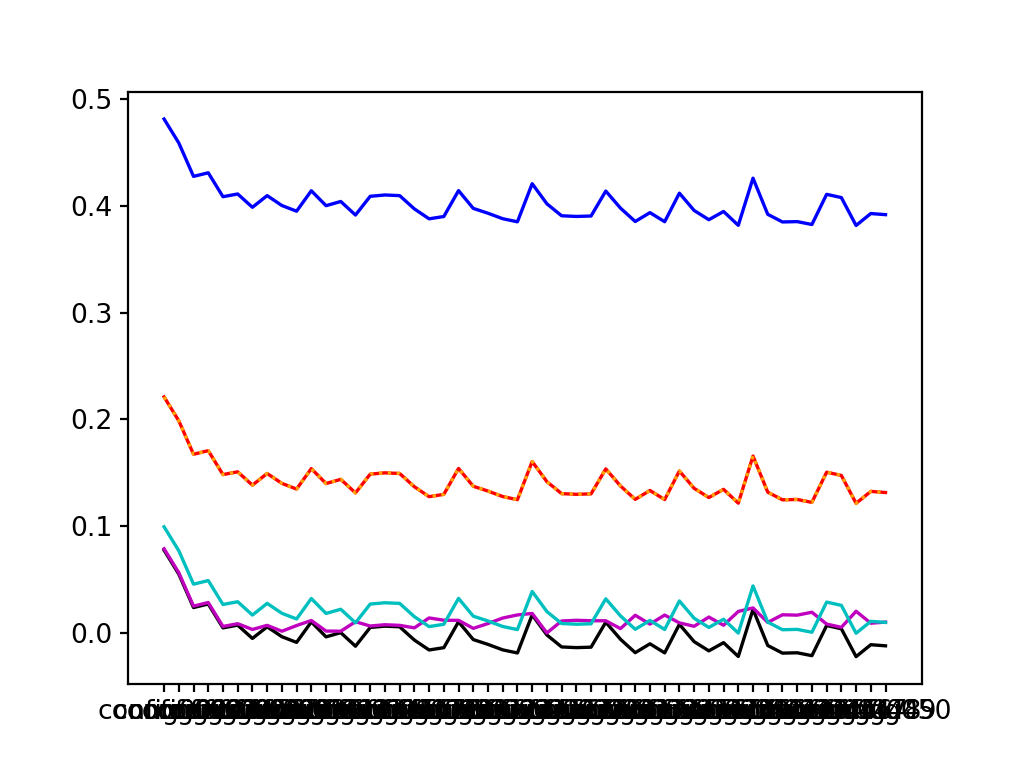

In [40]:
t = ndf0[ndf0['cell']==44].copy()
#t['response'] = t['response'] - x0['response'].min()
vectest = t.groupby(['config']).mean()

# ------

ndf = NDATA[(NDATA['datakey']=='20190510_JC083_fov1')].copy()

x0 = ndf[ndf['cell']==44]

vec = x0.groupby(['config']).mean()

x1 = x0.copy()
x1['response'] = x0['response'] - x0['response'].min()
vec0 = x1.groupby(['config']).mean()

x2 = x0.copy()
x2['response'] = x0['response'] - NDATA[(NDATA['datakey']=='20190510_JC083_fov1')]['response'].min()
vec00 = x2.groupby(['config']).mean()


vec1 = np.abs(vec['response'] - vec['response'].mean())
vec2 = vec['response'] - vec['response'].min()


pl.figure()
pl.plot(vec['response'], 'k')
pl.plot(vec1, 'm')
pl.plot(vec2, 'c')

pl.plot(vec0['response'], 'r')
pl.plot(vec00['response'], 'b')

pl.plot(vectest['response'], 'orange', linestyle=':')

<IPython.core.display.Javascript object>


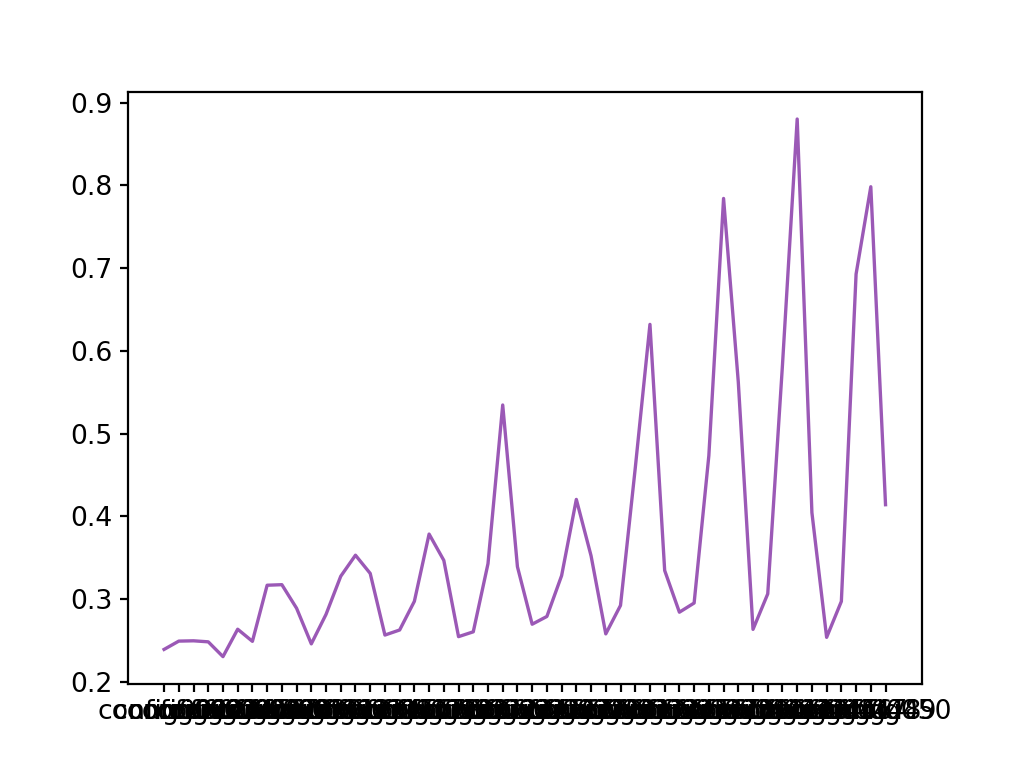

In [1253]:
pl.figure()
pl.plot(vec0['response'])


In [49]:
images_only=True
ixdf = selectivity_and_tolerance(NDATA, SDF, images_only=True)
ixdf.tail()

cell  size_tol  morph_ix  sparseness visual_area              datakey
2958   364  0.829823  0.113115    0.017712          V1  20191006_JC110_fov1
2959   375  0.809471  0.096838    0.004565          V1  20191006_JC110_fov1
2960   380  0.905538  0.094988    0.003246          V1  20191006_JC110_fov1
2961   383  0.888641  0.074614    0.004641          V1  20191006_JC110_fov1
2962   390  0.902053  0.115427    0.004775          V1  20191006_JC110_fov1

In [50]:
ixdf[['visual_area', 'datakey']].drop_duplicates()['visual_area'].value_counts()

Li    18
Lm    17
V1    16
Name: visual_area, dtype: int64

In [51]:
ixdf.min()

cell                             0
size_tol                  0.303209
morph_ix                 0.0156626
sparseness             0.000273964
visual_area                     Li
datakey        20190306_JC061_fov3
dtype: object

In [52]:
ixdf.max()

cell                           530
size_tol                  0.983383
morph_ix                  0.480127
sparseness                0.217726
visual_area                     V1
datakey        20191111_JC120_fov1
dtype: object

#### Drop repeats?

In [1204]:
# ixdf0 = ixdf[(ixdf['morph_ix']<=1) & (ixdf['morph_ix']>=0)
#     & (ixdf['sparseness']<=1) & (ixdf['sparseness']>=0)
#     & (ixdf['size_tol']<=1) & (ixdf['size_tol']>=0)].copy()



In [53]:
min_ncells = 1
passdf = pd.concat([g for v, g in ixdf.groupby(['visual_area', 'datakey']) \
                    if (len(g) >= min_ncells) ]) #& (g['morph_ix'])])

In [54]:
passdf['morph_ix'].max()

0.4801273101731681

In [55]:
metric = 'heldout_test_score'
drop_repeats_by = 'most_cells'

# Drop repeat FOVs
pCELLS = pd.concat([CELLS[(CELLS.visual_area==v) & (CELLS.datakey==dk)] \
               for (v, dk), g in passdf.groupby(['visual_area', 'datakey'])])\
                        .groupby(['visual_area', 'datakey']).count().reset_index()
pCELLS = putils.split_datakey(pCELLS)

unique_dsets = aggr.select_best_fovs(pCELLS) #, criterion='max', colname='cell')


[V1] Animalid does not exist: JC078 


In [56]:
unique_dsets.shape

(43, 10)

In [57]:
drop_repeats = True
dset_str = 'drop_repeats_%s' % drop_repeats_by if drop_repeats else 'alldata'

excl_dsets = ['20190501_JC076_fov1', '20190627_JC091_fov1'] #['20190507_JC083_fov1'] #, '20190501_JC076_fov1'] #, '20190617_JC099_fov1'] #'20191018_JC113_fov1']
#excl_dsets = ['20191018_JC113_fov1', '20191111_JC120_fov1']

unique_dkeys = [(v, k) for (v, k), g in unique_dsets.groupby(['visual_area', 'datakey'])]

passdf_drop = pd.concat([g for (v, k), g in passdf.groupby(['visual_area', 'datakey'])\
                        if (v, k) in unique_dkeys and k not in excl_dsets])

print("All data:")
print(passdf[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area']).count())
print("Drop repeats:")
print(passdf_drop[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area']).count())


All data:
             datakey
visual_area         
Li                18
Lm                17
V1                16
Drop repeats:
             datakey
visual_area         
Li                13
Lm                10
V1                 8


In [58]:
xdf = passdf_drop.copy() if drop_repeats else passdf.copy()
means_by_fov = xdf.groupby(['visual_area', 'datakey']).mean().reset_index()

ncells_by_fov = xdf.groupby(['visual_area', 'datakey']).count().reset_index()[['visual_area', 'datakey', 'cell']]\
                    .rename(columns={'cell': 'n_cells'})
mean_indices = pd.merge(means_by_fov, ncells_by_fov, on=['visual_area', 'datakey'])

                   cell  size_tol  morph_ix  sparseness     n_cells
visual_area                                                        
Li           156.024242  0.852488  0.108486    0.005811   31.769231
Lm           132.094916  0.818709  0.120259    0.009184   64.700000
V1           179.944119  0.815167  0.126753    0.014423  124.375000


<IPython.core.display.Javascript object>


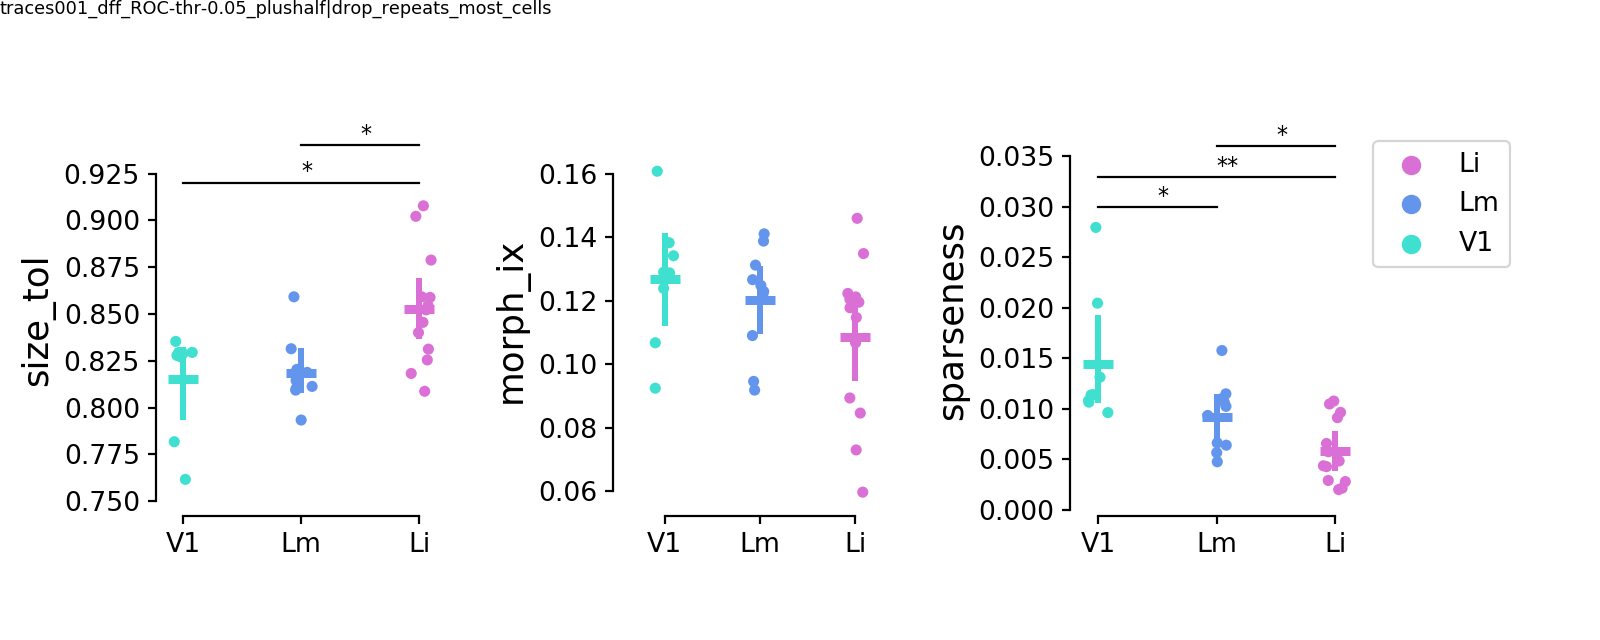

********* [size_tol] Mann-Whitney U test(mc=fdr_bh) **********
   U_val  d1  d2  n1  n2     p_val  reject
0   31.0  V1  Lm   8  10  0.225051   False
1   19.0  V1  Li   8  13  0.013942    True
2   23.0  Lm  Li  10  13  0.013942    True
****************************
********* [morph_ix] Mann-Whitney U test(mc=fdr_bh) **********
   U_val  d1  d2  n1  n2     p_val  reject
0   32.0  V1  Lm   8  10  0.252580   False
1   26.0  V1  Li   8  13  0.085333   False
2   39.0  Lm  Li  10  13  0.085333   False
****************************
********* [sparseness] Mann-Whitney U test(mc=fdr_bh) **********
   U_val  d1  d2  n1  n2     p_val  reject
0   17.0  V1  Lm   8  10  0.022795    True
1    4.0  V1  Li   8  13  0.000873    True
2   28.0  Lm  Li  10  13  0.017697    True
****************************
('/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/selectivity_tolerance', 'aggregate_metrics_byfov__drop_repeats_most_cells')


In [63]:
plot_cells=False

plot_str = 'bycell' if plot_cells else 'byfov'
if plot_cells:
    plotdf = xdf.copy()
else:
    plotdf = mean_indices.copy()

print(plotdf.groupby(['visual_area']).mean())

fig, axn = pl.subplots(1,3, figsize=(10,4))

ax=axn[0]
multi_comp_test='fdr_bh'

metric='size_tol'
for ai, metric in enumerate(['size_tol', 'morph_ix']):
    ax=axn[ai]
    sns.stripplot(x='visual_area', y=metric, data=plotdf, ax=ax,
                 hue='visual_area', palette=area_colors, order=visual_areas)
    sns.pointplot(x='visual_area', y=metric, data=plotdf, ax=ax,
                 hue='visual_area', palette=area_colors, order=visual_areas, join=False, 
                 markers='_', scale=2)
    ax.legend_.remove()
    if metric=='size_tol':
        y_loc = 0.9
        offset = 0.02
    else:
        y_loc = 0.35 if plot_cells else 0.07
        offset = 0.02 if plot_cells else 0.01
    statresults, ax = aggr.plot_mannwhitney(plotdf, metric=metric, ax=ax, 
                                        multi_comp_test=multi_comp_test, y_loc=y_loc, offset=offset)
ax=axn[2]
metric='sparseness'
y_loc=0.1 if plot_cells else 0.03 #0.008 
offset=0.005 if plot_cells else 0.003
sns.stripplot(x='visual_area', y=metric, data=plotdf, ax=ax,
                 hue='visual_area', palette=area_colors, order=visual_areas)
sns.pointplot(x='visual_area', y=metric, data=plotdf, ax=ax,
                 hue='visual_area', palette=area_colors, order=visual_areas, join=False, 
                 markers='_', scale=2)
statresults, ax = aggr.plot_mannwhitney(plotdf, metric=metric, ax=ax, 
                                    multi_comp_test=multi_comp_test, y_loc=y_loc, offset=offset)


sns.despine(offset=2, trim=True)
pl.subplots_adjust(bottom=0.2, left=0.1, right=0.85, top=0.8, wspace=0.6)
aggr.crop_legend_labels(ax, n_hues=3, bbox_to_anchor=(1, 1), loc='upper left') #title='pass(p<%.2f)' % p_thr)

for ax in axn.flat:
    ax.set_xlabel('')
    
putils.label_figure(fig, '%s|%s' % (data_id, dset_str))

figname = 'aggregate_metrics_%s__%s' % (plot_str, dset_str)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

In [64]:
min_ncells = 10

c_=[]
for (va, dk), ixs_ in xdf.groupby(['visual_area', 'datakey']):
    if len(ixs_) < min_ncells:
        continue
    for sel_type in ['morph_ix', 'sparseness']:
        pearsons_r, pearsons_p = spstats.pearsonr(ixs_['size_tol'], ixs_[sel_type])
        c = pd.Series({'selectivity': sel_type, 
                   'pearsons_p': pearsons_p, 'pearsons_r': pearsons_r,
                   'visual_area': va, 'datakey': dk, 'n_cells': len(ixs_)})
        c_.append(c)

corrs = pd.concat(c_, axis=1).T

p_thr=0.05
corrs['pass'] = corrs['pearsons_p'] < p_thr

<IPython.core.display.Javascript object>


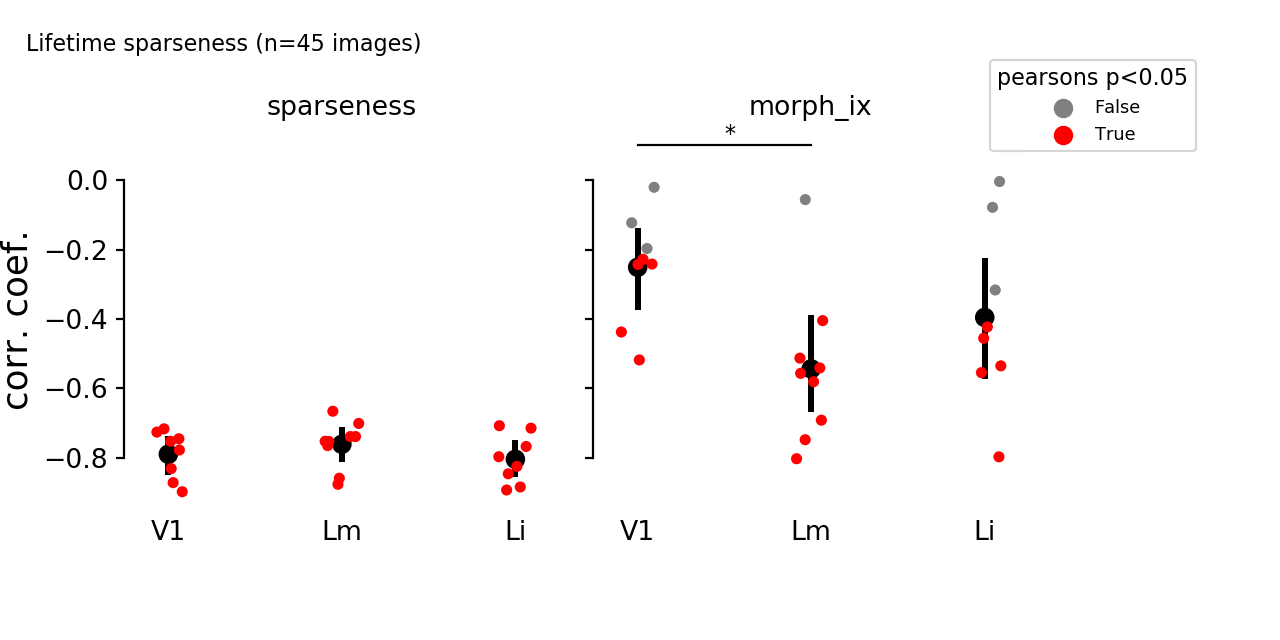

********* [pearsons_r] Mann-Whitney U test(mc=fdr_bh) **********
   U_val  d1  d2  n1  n2     p_val  reject
0   29.0  V1  Lm   8   9  0.398751   False
1   30.0  V1  Li   8   8  0.437413   False
2   22.0  Lm  Li   9   8  0.290896   False
****************************
********* [pearsons_r] Mann-Whitney U test(mc=fdr_bh) **********
   U_val  d1  d2  n1  n2     p_val  reject
0   10.0  V1  Lm   8   9  0.021207    True
1   20.0  V1  Li   8   8  0.113573   False
2   21.0  Lm  Li   9   8  0.113573   False
****************************


Text(0.02,0.92,u'Lifetime sparseness (n=45 images)')

In [66]:
fig, axn = pl.subplots(1,2, figsize=(8, 4), sharex=True, sharey=True)
n_images = 45 
plotd = corrs.copy() #[corrs['pass']].copy()

ax=axn[0]
for ai, (ax, sel_type) in enumerate(zip(axn.flat, ['sparseness', 'morph_ix'])):
    sns.stripplot(x='visual_area', y='pearsons_r', data=plotd[plotd.selectivity==sel_type], ax=ax,
                 hue='pass', palette={True: 'r', False: 'gray'}, dodge=False, order=visual_areas)
    
    sns.pointplot(x='visual_area', y='pearsons_r', data=plotd[plotd.selectivity==sel_type], ax=ax,
                 color='k', dodge=False, join=False, order=visual_areas)
    y_loc=0.1
    offset=0.1
    statresults, ax = aggr.plot_mannwhitney(plotd[plotd.selectivity==sel_type], metric='pearsons_r', ax=ax, 
                                    multi_comp_test=multi_comp_test, y_loc=y_loc, offset=offset)
    ax.set_title(sel_type, fontsize=12)
    if ai==0:
        ax.legend_.remove()
        ax.set_ylabel('corr. coef.')
    else:
        ax.set_ylabel('')
    ax.tick_params(which='both', axis='x', size=0)
    ax.set_xlabel('')

sns.despine(offset=2, trim=True, bottom=True)

aggr.crop_legend_labels(ax, n_hues=3, bbox_to_anchor=(0.9,1.2), loc='upper left', 
                        title='pearsons p<%.2f' % p_thr, fontsize=8)
pl.subplots_adjust(left=0.1, right=0.8, bottom=0.2, top=0.8, wspace=0.1)

fig.text(0.02, 0.92, 'Lifetime sparseness (n=%i images)' % n_images)

In [67]:
ixs = passdf[(passdf.visual_area=='V1') & (passdf.datakey=='20190510_JC083_fov1')].copy()
ixs.sort_values(by='size_tol', ascending=False).iloc[0:5]

cell  size_tol  morph_ix  sparseness visual_area              datakey
1931    86  0.967710  0.128465    0.006768          V1  20190510_JC083_fov1
1924    76  0.956093  0.055719    0.000983          V1  20190510_JC083_fov1
1893     0  0.951939  0.072385    0.001331          V1  20190510_JC083_fov1
1942   124  0.940871  0.173290    0.003630          V1  20190510_JC083_fov1
1953   148  0.939295  0.058693    0.002698          V1  20190510_JC083_fov1

# Tradeoff? Look at correlations closer

In [68]:
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn import metrics as skmetrics
import random
import sklearn.utils as skutils

In [69]:
# curr_dsets = [(v, k) for v, k in corrs_drop[['visual_area', 'datakey']].drop_duplicates().values]
# curr_dsets

In [70]:
corrs['n_cells'].min()
print(excl_dsets)

['20190501_JC076_fov1', '20190627_JC091_fov1']


In [71]:
unique_dkeys = [(v, k) for (v, k), g in unique_dsets.groupby(['visual_area', 'datakey'])]
# curr_df = pd.concat([g for (v, k), g in passdf.groupby(['visual_area', 'datakey']) \
#                     if ((v, k) in unique_dkeys) & (len(g['cell'].unique())>=min_ncells)])
curr_df = pd.concat([g for (v, k), g in passdf_drop.groupby(['visual_area', 'datakey']) \
                    if (len(g['cell'].unique())>=min_ncells) & (k not in excl_dsets)])

visual_area='V1'

for visual_area in visual_areas:
    vg= curr_df[curr_df.visual_area==visual_area].copy()
    n_fovs = len(vg['datakey'].unique())
    print(visual_area, n_fovs)

('V1', 8)
('Lm', 9)
('Li', 8)


<IPython.core.display.Javascript object>


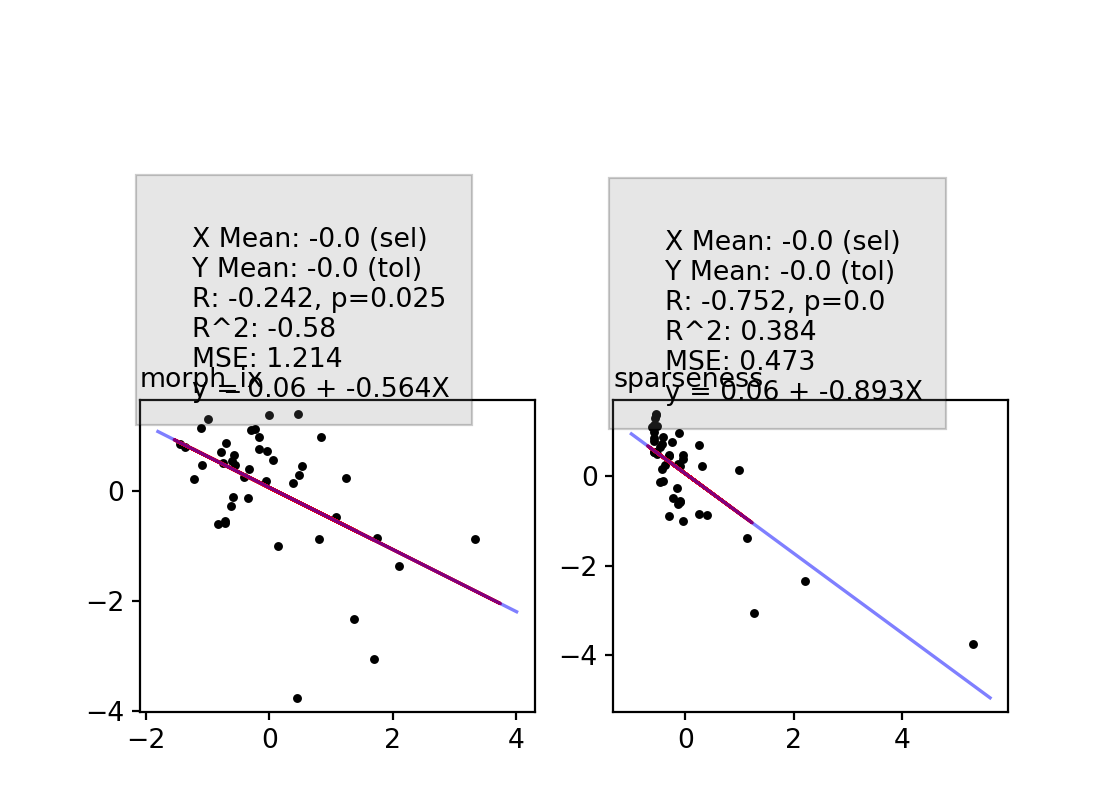

In [74]:
visual_area='V1'
datakey = '20191006_JC110_fov1'
sel_type = 'morph_ix'

ixs_ = passdf[(passdf.visual_area==visual_area) & (passdf.datakey==datakey)].copy()

fig, axn  = pl.subplots(1,2,figsize=(7,5))
for ax, sel_type in zip(axn.flat, ['morph_ix', 'sparseness']):
    xx_ = ixs_[sel_type].values.reshape(-1, 1)
    yy_ = ixs_['size_tol'].values.reshape(-1, 1)
    
    xx = (xx_ - np.mean(xx_)) / np.std(xx_)
    yy = (yy_ - np.mean(yy_)) / np.std(yy_)
    
    X_train, X_test, y_train, y_test = train_test_split(xx, yy, test_size=0.5, shuffle=True, random_state=100)
    
    # Fit OLS
    scaler  = preprocessing.StandardScaler().fit(X_train)
    x_train = scaler.transform(X_train)
    regr = linear_model.LinearRegression().fit(x_train, y_train)
    x_test = scaler.transform(X_test)
    y_pred = regr.predict(x_test)
    
    # metrics
    pearsons_r, pearsons_p = spstats.pearsonr(xx, yy)
    R2 = skmetrics.r2_score(y_test, y_pred)
    MSE = skmetrics.mean_squared_error(y_test, y_pred)
    B0 = float(regr.intercept_)
    B1 = float(regr.coef_)
    res = {'pearsons_r': pearsons_r, 'pearsons_p': pearsons_p, 'R2': R2, 'MSE': MSE, 
           'coef': B0, 'intercept': B1, 'selectivity': sel_type}
    
    ax.scatter(x_train, y_train, color='k', marker='.')
    ax.plot(x_test, y_pred, color='r')
    
    text = '''
    X Mean: {} (sel)
    Y Mean: {} (tol)
    R: {}, p={}
    R^2: {}
    MSE: {}
    y = {} + {}X'''\
                    .format(round(xx.mean(), 2), 
                           round(yy.mean(), 2), 
                           round(pearsons_r, 3), round(pearsons_p, 3), 
                           round(R2, 3),
                           round(MSE, 3),
                           round(B0, 3),
                           round(B1, 3))
    ax.text(x=ax.get_xlim()[0], y=ax.get_ylim()[-1]+.05, s=text, fontsize=12, 
            bbox={'facecolor': 'grey', 'alpha': 0.2, 'pad': 10})
    
    xmin, xmax = ax.get_xlim()
    xvs = np.linspace(xmin, xmax, num=5)
    ax.plot(xvs, B0 + B1*xvs, c='b', alpha=0.5)
    ax.set_title(sel_type, loc='left')
    
pl.subplots_adjust(top=0.5)



In [75]:
max_nfovs

NameError: name 'max_nfovs' is not defined

In [76]:
visual_area, dk, sel_type

('V1', '20191006_JC110_fov1', 'sparseness')

In [77]:
max_nfovs = curr_df[['visual_area', 'datakey']].drop_duplicates()['visual_area'].value_counts().max()
max_nfovs

9

<IPython.core.display.Javascript object>


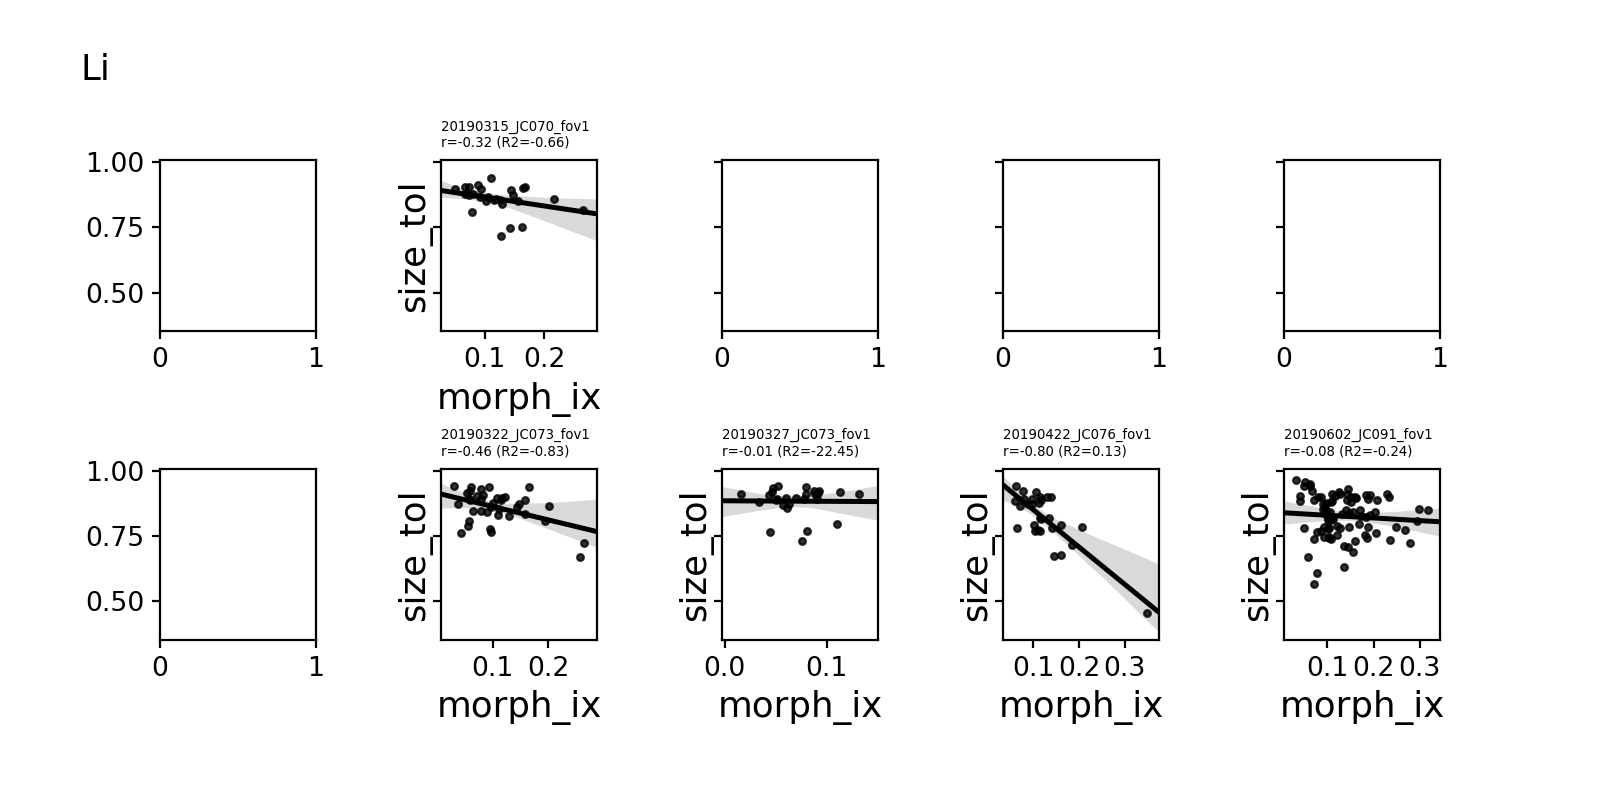

Bad fit: 20190315_JC070_fov1 (R2=-0.66)
Bad fit: 20190322_JC073_fov1 (R2=-0.83)
Bad fit: 20190327_JC073_fov1 (R2=-22.45)
Bad fit: 20190602_JC091_fov1 (R2=-0.24)


<IPython.core.display.Javascript object>


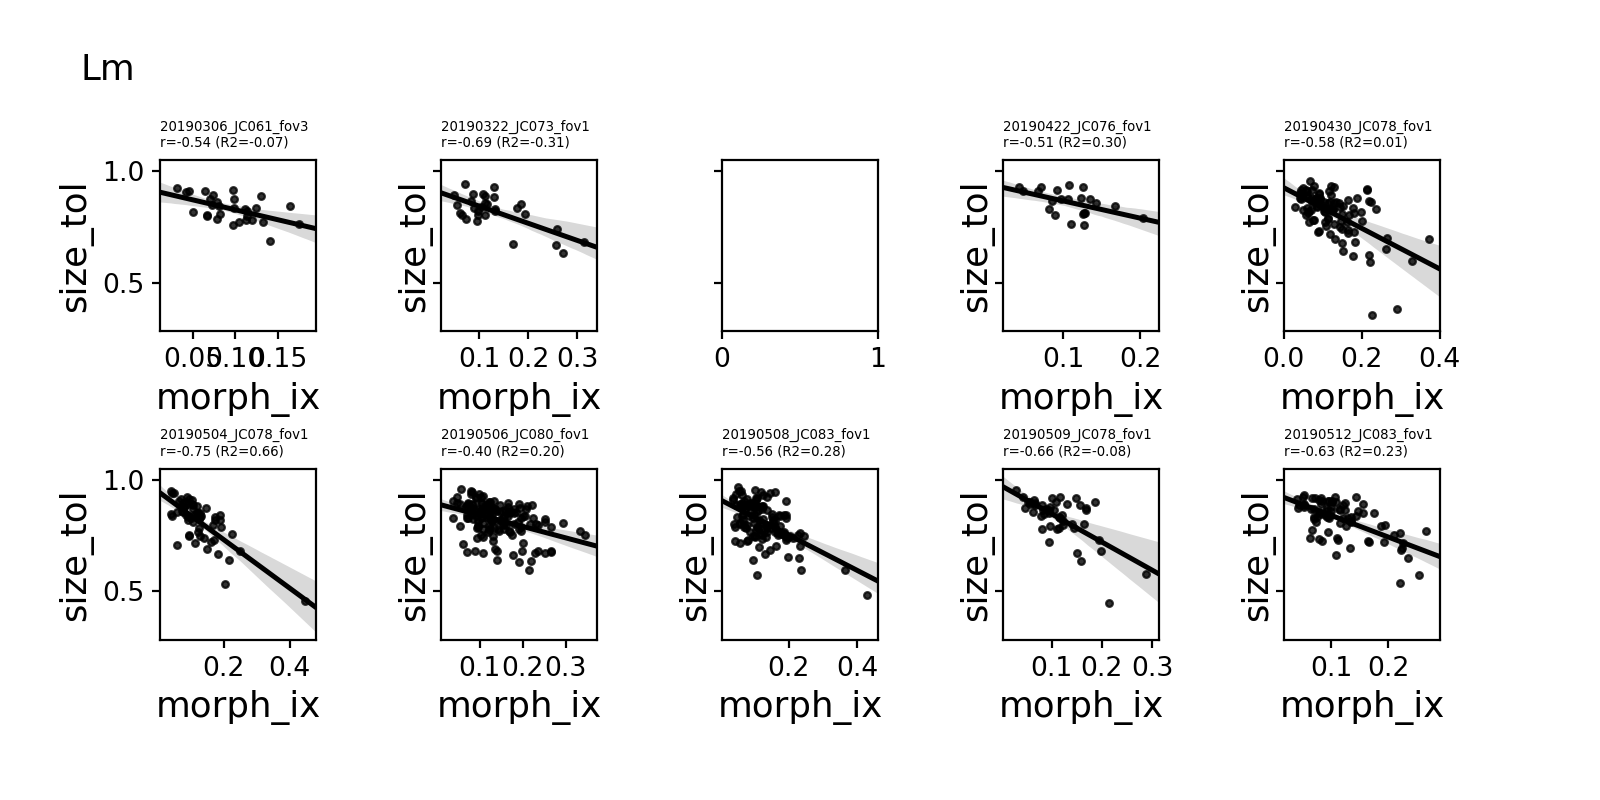

Bad fit: 20190306_JC061_fov3 (R2=-0.07)
Bad fit: 20190322_JC073_fov1 (R2=-0.31)
Bad fit: 20190509_JC078_fov1 (R2=-0.08)


<IPython.core.display.Javascript object>


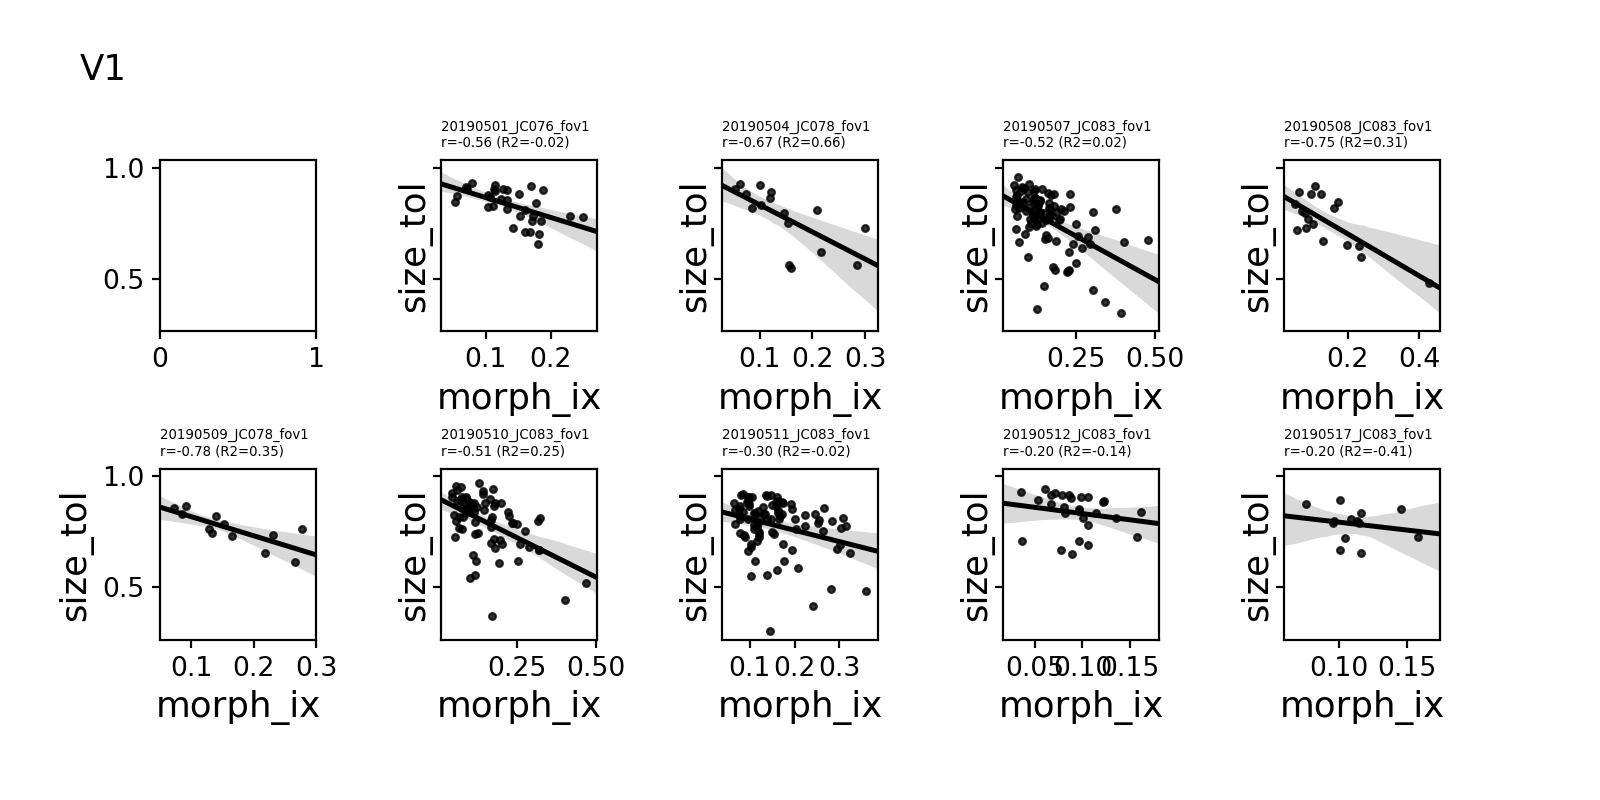

Bad fit: 20190501_JC076_fov1 (R2=-0.02)
Bad fit: 20190511_JC083_fov1 (R2=-0.02)
Bad fit: 20190512_JC083_fov1 (R2=-0.14)
Bad fit: 20190517_JC083_fov1 (R2=-0.41)


MSE        R2       coef              datakey intercept n_cells  \
0   1.99391 -0.660654   0.492129  20190315_JC070_fov1 -0.249694      27   
1   1.00293 -0.828283  -0.210237  20190322_JC073_fov1 -0.604327      38   
2   3.48606  -22.4452  -0.839103  20190327_JC073_fov1 -0.807067      27   
3  0.402154  0.127894  0.0249606  20190422_JC076_fov1 -0.872884      29   
4   1.32056 -0.236379   0.235879  20190602_JC091_fov1 -0.220633      87   

    pearsons_p  pearsons_r selectivity visual_area  
0     0.108021   -0.316263    morph_ix          Li  
1   0.00408482   -0.455195    morph_ix          Li  
2     0.961804 -0.00967393    morph_ix          Li  
3  2.31386e-07   -0.796839    morph_ix          Li  
4     0.471357  -0.0782345    morph_ix          Li

In [78]:
sel_type = 'morph_ix'

r_ = []
for visual_area, vg in passdf.groupby(['visual_area']):
    
    n_fovs = len(vg['datakey'].unique())

    fig, axn = pl.subplots(2, 5, figsize=(10, 5), sharex=False, sharey=True)
    for ax, (datakey, ixs_) in zip(axn.flat, vg.groupby(['datakey'])):
        if len(ixs_) < min_ncells:
            continue
        #print(datakey, ixs_.shape)
        xx_ = ixs_[sel_type].values.reshape(-1, 1)
        yy_ = ixs_['size_tol'].values.reshape(-1, 1)
        
        xx = (xx_ - np.mean(xx_)) / np.std(xx_)
        yy = (yy_ - np.mean(yy_)) / np.std(yy_)
        X_train, X_test, y_train, y_test = train_test_split(xx, yy, test_size=0.5, shuffle=False, random_state=20)

        # Fit OLS
        scaler  = preprocessing.StandardScaler().fit(X_train)
        x_train = scaler.transform(X_train)
        x_train = X_train.copy()
        regr = linear_model.LinearRegression().fit(x_train, y_train)
        x_test = scaler.transform(X_test)
        x_test = X_test.copy()
        y_pred = regr.predict(x_test)

        # metrics
        pearsons_r, pearsons_p = spstats.pearsonr(xx, yy)
        R2 = skmetrics.r2_score(y_test, y_pred)
        if R2<0:
            print("Bad fit: %s (R2=%.2f)" % (datakey, R2))
            #continue
            
        MSE = skmetrics.mean_squared_error(y_test, y_pred)
        B0 = float(regr.intercept_)
        B1 = float(regr.coef_)
        res = {'pearsons_r': float(pearsons_r), 'pearsons_p': float(pearsons_p), 'R2': R2, 'MSE': MSE, 
               'coef': B0, 'intercept': B1, 'selectivity': sel_type,
               'visual_area': visual_area, 'datakey': datakey, 'n_cells': len(xx)}
        # plot
        #ax.scatter(xx, yy, color='k', marker='.', s=2)
        sns.regplot(sel_type, 'size_tol', data=ixs_, color='k', marker='.', ax=ax) #, size=2)\
        lc = 'r' if R2>0.5 else 'k'
#         ax.plot(x_test, y_pred, color=lc)
            
#         xmin, xmax = ax.get_xlim()
#         xvs = np.linspace(xmin, xmax, num=5)
    
#         ax.plot(xvs, B0 + B1*xvs, c=lc, alpha=0.5)
        ax.set_title('%s\nr=%.2f (R2=%.2f)' % (datakey, pearsons_r, R2), loc='left', fontsize=6)
        
        r_.append(pd.Series(res))
    pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8, wspace=0.8, hspace=0.8)
    fig.text(0.05, 0.9, visual_area, fontsize=16)

regressiondf = pd.concat(r_, axis=1).T #reset_index(drop=True)
regressiondf[regressiondf.visual_area=='Li']

<IPython.core.display.Javascript object>


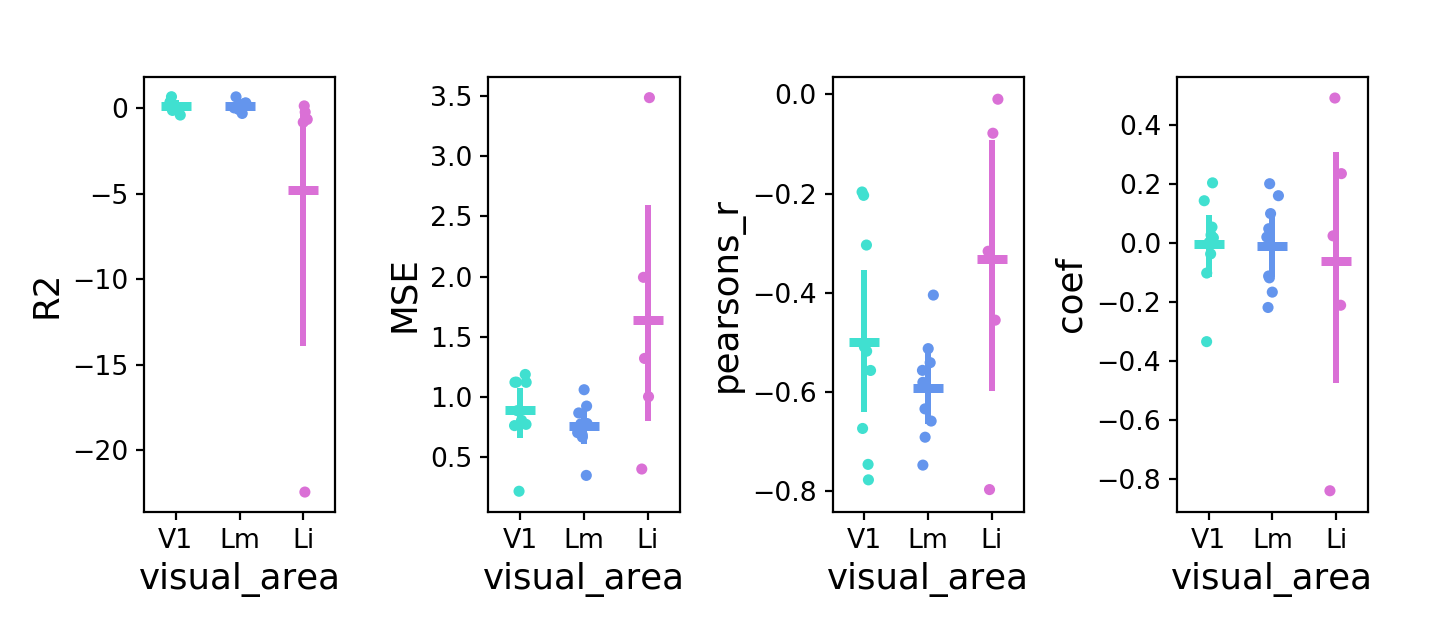

In [79]:
plot_params = ['R2', 'MSE', 'pearsons_r', 'coef']
fig, axn = pl.subplots(1, len(plot_params), figsize=(9, 4))
for ax, p in zip(axn.flat, plot_params):
    sns.stripplot(x='visual_area', y=p, data=regressiondf, ax=ax, 
                 order=visual_areas, hue='visual_area', palette=area_colors)
    sns.pointplot(x='visual_area', y=p, data=regressiondf, ax=ax, 
                 order=visual_areas, hue='visual_area', palette=area_colors,
                 markers='_', scale=2, join=False)
    ax.legend_.remove()

pl.subplots_adjust(left=0.1, right=0.95, wspace=0.8, bottom=0.2)

In [80]:


visual_area='Lm'
datakey = '20190525_JC084_fov1'
sel_type = 'morph_ix'

ixs_ = passdf[(passdf.visual_area==visual_area) & (passdf.datakey==datakey)].copy()

xx = ixs_[sel_type].values
yy = ixs_['size_tol'].values

pearsons_r, pearsons_p = spstats.pearsonr(xx, yy)

n_iters=1000
n_cells = len(xx)
ixdf = pd.DataFrame({'xx': xx, 'yy': yy})

shuff = np.concatenate((xx, yy))

s_=[]
b_=[]
for i in np.arange(0, n_iters):
    
#     np.random.shuffle(xx)
#     np.random.shuffle(yy)
    resample_ = ixs_.sample(n=n_cells, replace=True)
    xx = resample_[sel_type].values
    yy = resample_['size_tol'].values
    boot_r, boot_p = spstats.pearsonr(xx, yy)
    b_.append((boot_r, boot_p))
    
    np.random.shuffle(xx)
    np.random.shuffle(yy)
    shuff_r, shuff_p = spstats.pearsonr(xx, yy)
    s_.append((shuff_r, shuff_p))
    

shuff_results = pd.DataFrame(s_, columns=['r', 'p'])
boot_results = pd.DataFrame(b_, columns=['r', 'p'])

p_val = shuff_results[shuff_results['r']<pearsons_r].shape[0]/float(n_iters)


<IPython.core.display.Javascript object>


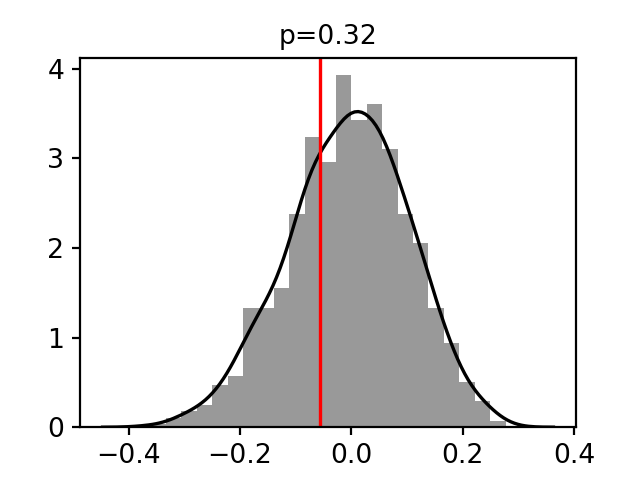

In [81]:
fig, ax = pl.subplots(figsize=(4,3))
ax.set_title('p=%.2f' % p_val)
sns.distplot(shuff_results['r'], color='k')
ax.axvline(x=pearsons_r, color='r')

# lo, hi = putils.get_empirical_ci(boot_results['r'])
# sns.distplot(boot_results['r'], color='b')
# ax.axvline(x=lo, linestyle=':', c='b')
# ax.axvline(x=hi, linestyle=':', c='b')


In [1341]:
shuff_results['r'].std()

0.10465899254981435

In [82]:
curr_df = pd.concat([g for (v, k), g in passdf_drop.groupby(['visual_area', 'datakey']) \
                    if (len(g['cell'].unique())>=min_ncells) & (k not in excl_dsets)])


In [83]:
n_iters=5000

sel_type = 'morph_ix'
r_ = []
for (visual_area, datakey), ixs_ in passdf_drop.groupby(['visual_area', 'datakey']):
    if len(ixs_) < min_ncells:
        continue
    xx = ixs_[sel_type].values
    yy = ixs_['size_tol'].values

    pearsons_r, pearsons_p = spstats.pearsonr(xx, yy)

    n_points = len(xx)
    shuff = np.concatenate((xx, yy))

    s_=[]
    for i in np.arange(0, n_iters):
        np.random.shuffle(xx)
        np.random.shuffle(yy)
        shuff_r, shuff_p = spstats.pearsonr(xx, yy)
        s_.append((shuff_r, shuff_p))

    shuff_results = pd.DataFrame(s_, columns=['r', 'p'])
    p_val = shuff_results[shuff_results['r']<pearsons_r].shape[0]/float(n_iters)
    
    r_.append((visual_area, datakey, p_val, pearsons_r, n_points))

resdf = pd.DataFrame(r_, columns=['visual_area', 'datakey', 'p_val', 'pearsons_r', 'n_cells'])


print(resdf.shape)
print(resdf[resdf['p_val']<0.05].shape)


(25, 5)
(18, 5)


<IPython.core.display.Javascript object>


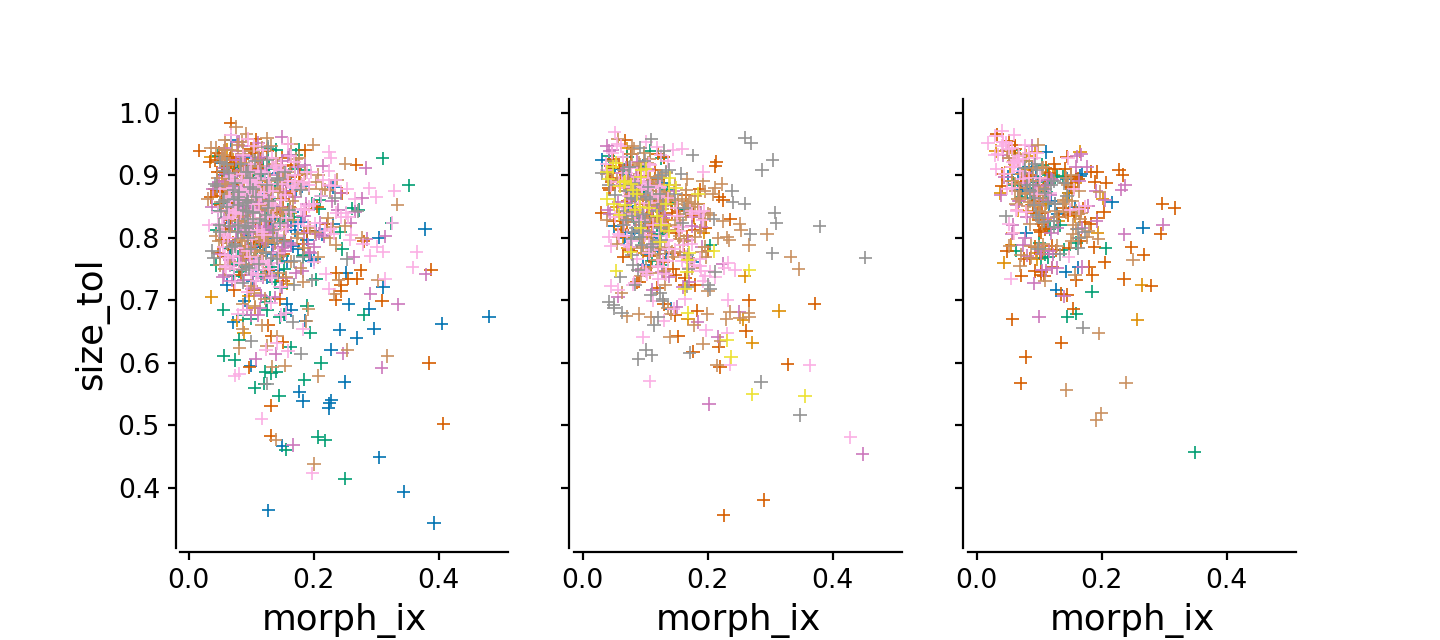

In [84]:
ymin, ymax = curr_df['size_tol'].min(), curr_df['size_tol'].max()
xmin, xmax = curr_df[sel_type].min(), curr_df[sel_type].max()
xlim = ymax-ymin

fig, axn = pl.subplots(1,3,figsize=(9,4), sharex=True, sharey=True)
for va, vg in curr_df.groupby(['visual_area']): #, 'datakey']):
    ai = visual_areas.index(va)
    ax=axn[ai]
    
    sns.scatterplot(x=sel_type, y='size_tol', data=vg, ax=ax,
                   hue='datakey', palette='colorblind', marker='+')
    ax.legend_.remove()
    
for ax in axn.flat:
    #ax.set_xlim([0, 0.5])
    #ax.set_ylim([0.5, 1])
    ax.set(adjustable='box-forced', aspect='equal')
    sns.despine(offset=2)

In [86]:
resdf[resdf['p_val']<p_thr][['visual_area', 'datakey']].drop_duplicates()['visual_area'].value_counts()

Lm    8
Li    5
V1    5
Name: visual_area, dtype: int64

               p_val  pearsons_r  n_cells
visual_area                              
Li           0.00204   -0.552778   44.400
Lm           0.00115   -0.604507   69.375
V1           0.00356   -0.333448  132.800


<IPython.core.display.Javascript object>


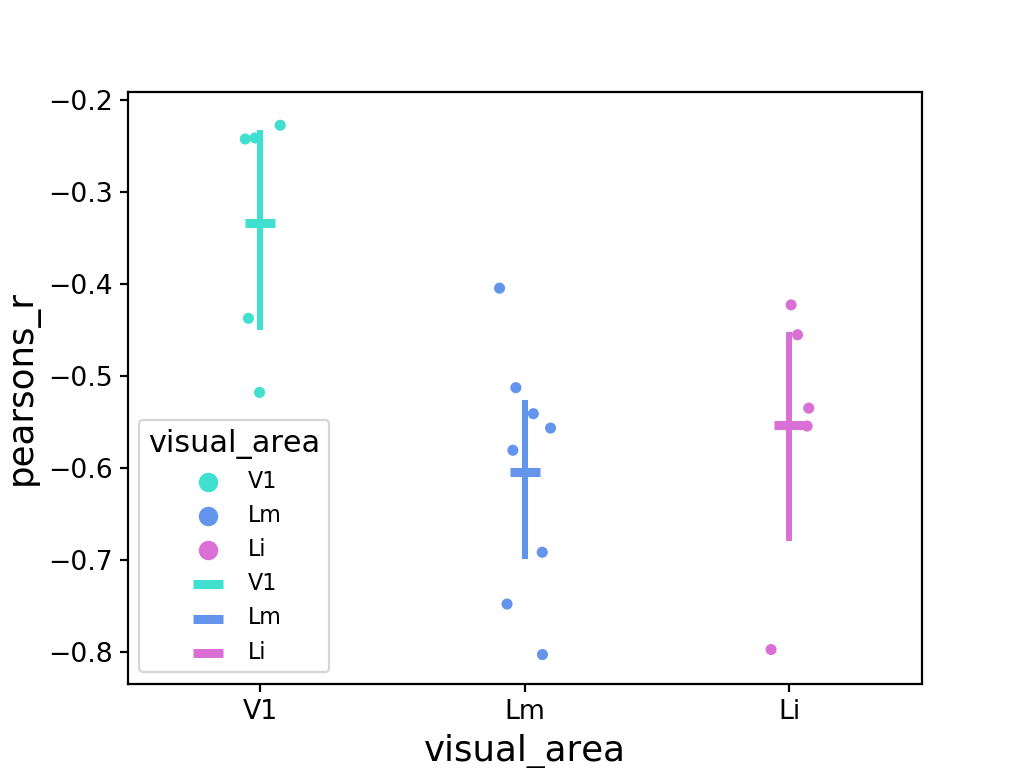

   U_val  d1  d2  n1  n2     p_val  reject
0   10.0  V1  Lm   8   9  0.038879    True
1   20.0  V1  Li   8   8  0.208218   False
2   21.0  Lm  Li   9   8  0.208218   False


U_val  d1  d2  n1  n2     p_val  reject
0   10.0  V1  Lm   8   9  0.038879    True
1   20.0  V1  Li   8   8  0.208218   False
2   21.0  Lm  Li   9   8  0.208218   False

In [87]:
multi_comp_test='fdr_by'
p_thr=0.05

print(resdf[resdf['p_val']<p_thr].groupby(['visual_area']).mean())

fig, ax = pl.subplots()
sns.stripplot(x='visual_area', y='pearsons_r', data=resdf[resdf['p_val']<p_thr], ax=ax,
              hue='visual_area', palette=area_colors, order=visual_areas, hue_order=visual_areas)
sns.pointplot(x='visual_area', y='pearsons_r', data=resdf[resdf['p_val']<p_thr], ax=ax,
              hue='visual_area', palette=area_colors, markers='_', scale=2, join=False,
             order=visual_areas, hue_order=visual_areas)

aggr.do_mannwhitney(resdf, metric='pearsons_r', multi_comp_test=multi_comp_test)


In [1359]:
resdf

visual_area              datakey  p_val  pearsons_r  n_cells
0           Li  20190315_JC070_fov1  0.129   -0.221801       27
1           Li  20190322_JC073_fov1  0.000   -0.483181       38
2           Li  20190422_JC076_fov1  0.062   -0.297974       29
3           Li  20190602_JC091_fov1  0.412   -0.022337       87
4           Li  20190609_JC099_fov1  0.959    0.228308       57
5           Li  20190614_JC091_fov1  0.000   -0.459237       78
6           Li  20191018_JC113_fov1  0.215   -0.115923       47
7           Li  20191111_JC120_fov1  0.000   -0.610054       30
8           Lm  20190306_JC061_fov3  0.018   -0.399561       30
9           Lm  20190322_JC073_fov1  0.001   -0.567877       30
10          Lm  20190422_JC076_fov1  0.158   -0.248566       22
11          Lm  20190430_JC078_fov1  0.000   -0.435212       98
12          Lm  20190504_JC078_fov1  0.000   -0.481316       59
13          Lm  20190506_JC080_fov1  0.000   -0.375687      147
14          Lm  20190508_JC083_fov1  0.000   -0.528256      125
15          Lm  20190525_JC084_fov1  0.539    0.011328       91
16          Lm  20190618_JC097_fov1  0.000   -0.818914       44
17          V1  20190507_JC083_fov1  0.000   -0.500843       97
18          V1  20190512_JC083_fov1  0.563    0.046058       28
19          V1  20190522_JC084_fov1  0.005   -0.242460      107
20          V1  20190613_JC097_fov1  0.000   -0.367032      120
21          V1  20190616_JC097_fov1  0.000   -0.264877      184
22          V1  20190617_JC097_fov1  0.001   -0.259618      177
23          V1  20190622_JC085_fov1  0.000   -0.244689      196
24          V1  20191006_JC110_fov1  0.002   -0.340636       86

In [1348]:
resdf[resdf['p_val']<p_thr]

visual_area              datakey  p_val  pearsons_r  n_cells
3           Li  20190320_JC067_fov1  0.000         NaN        1
4           Li  20190321_JC070_fov1  0.000         NaN        1
5           Li  20190322_JC073_fov1  0.002   -0.483181       38
9           Li  20190614_JC091_fov1  0.000   -0.459237       78
12          Li  20191111_JC120_fov1  0.000   -0.610054       30
13          Lm  20190306_JC061_fov3  0.013   -0.399561       30
14          Lm  20190322_JC073_fov1  0.003   -0.567877       30
16          Lm  20190430_JC078_fov1  0.000   -0.435212       98
17          Lm  20190504_JC078_fov1  0.000   -0.481316       59
18          Lm  20190506_JC080_fov1  0.000   -0.375687      147
19          Lm  20190508_JC083_fov1  0.000   -0.528256      125
21          Lm  20190618_JC097_fov1  0.000   -0.818914       44
22          Lm  20191111_JC120_fov1  0.000         NaN        1
23          V1  20190507_JC083_fov1  0.000   -0.500843       97
25          V1  20190522_JC084_fov1  0.007   -0.242460      107
26          V1  20190613_JC097_fov1  0.000   -0.367032      120
27          V1  20190616_JC097_fov1  0.002   -0.264877      184
28          V1  20190617_JC097_fov1  0.000   -0.259618      177
29          V1  20190622_JC085_fov1  0.000   -0.244689      196
30          V1  20191006_JC110_fov1  0.001   -0.340636       86

In [1292]:
NDATA[(NDATA.visual_area=='V1') & (NDATA.datakey=='20190510_JC083_fov1')]['response'].min()

-0.40334947782439934

In [1293]:
print(NDATA.groupby(['visual_area'])['response'].min())

print(NDATA.groupby(['visual_area'])['response'].max())


visual_area
Li   -0.488944
Lm   -0.414147
V1   -0.556200
Name: response, dtype: float64
visual_area
Li    2.750405
Lm    3.866704
V1    4.968845
Name: response, dtype: float64


In [780]:
animalid = 'JC083'
session = '20190510'
fov = 'FOV1_zoom2p0x'
datakey='%s_%s_fov1' % (session, animalid)
visual_area='V1'

In [661]:
glob.glob(os.path.join(rootdir, animalid, session, fov,
                                '*%s_static' % (experiment), 'traces', '%s*' % traceid,
                                'data_arrays', '*.npz'))

['/n/coxfs01/2p-data/JC083/20190510/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_54393b_traces001_0152b8_traces001_d41efc_traces001_cd9df6_traces001_aab980_traces001_84e961_traces001_ba9020/data_arrays/datasets.npz',
 '/n/coxfs01/2p-data/JC083/20190510/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_54393b_traces001_0152b8_traces001_d41efc_traces001_cd9df6_traces001_aab980_traces001_84e961_traces001_ba9020/data_arrays/labels.npz',
 '/n/coxfs01/2p-data/JC083/20190510/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_54393b_traces001_0152b8_traces001_d41efc_traces001_cd9df6_traces001_aab980_traces001_84e961_traces001_ba9020/data_arrays/neuropil.npz',
 '/n/coxfs01/2p-data/JC083/20190510/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_54393b_traces001_0152b8_traces001_d41efc_traces001_cd9df6_traces001_aab980_traces001_84e961_traces001_ba9020/data_arrays/np_subtracted.npz',
 '/n/coxfs01/2p-data/JC083/20190510/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_54393b_t

In [690]:
soma_fpath = glob.glob(os.path.join(rootdir, animalid, session, fov,
                                '*%s_static' % (experiment), 'traces', '%s*' % traceid,
                                'data_arrays', 'np_subtracted.npz'))[0]
soma_fpath

'/n/coxfs01/2p-data/JC083/20190510/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_54393b_traces001_0152b8_traces001_d41efc_traces001_cd9df6_traces001_aab980_traces001_84e961_traces001_ba9020/data_arrays/np_subtracted.npz'

In [691]:
dset = np.load(soma_fpath)
dset.keys()


['f0',
 'labels_columns',
 'sconfigs',
 'file_ixs',
 'run_info',
 'labels_data',
 'data']

In [749]:
dset['data'].shape

(236250, 192)

In [692]:
dset['data'].min(), dset['data'].max()

(-1650.736078181193, 10082.88675394144)

In [693]:
dset['f0'].min(), dset['f0'].max(),  dset['f0'].mean()

(-189.8199491232108, 7448.278411045068, 60.58968248816426)

In [723]:
def to_uint16(values):
    offset = 32768
    tmp = np.zeros(values.shape, dtype='uint16')
    tmp[:] = values + offset
    
    return tmp.astype(float)

In [732]:
labels = pd.DataFrame(data=dset['labels_data'],columns=dset['labels_columns'])

In [724]:
tmp = dset['data'].copy()
fmp = dset['f0'].copy()


In [748]:
dset['data'].columns

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [725]:
tmp = to_uint16(tmp)
fmp = to_uint16(fmp)


In [739]:
test = tmp/fmp


In [740]:
test.min(), test.max()

(0.7801123930773821, 1.2435789534782482)

In [759]:
traces = pd.DataFrame(test, columns=np.arange(0, test.shape[1]))
traces.shape

(236250, 192)

In [760]:
test_df = aggr.traces_to_trials(traces, labels, epoch='plushalf', metric='mean')
test_df.head()

0         1         2         3         4         5         6  \
1  0.999610  1.000025  0.999316  0.991719  1.001486  1.001180  1.001287   
2  1.000796  1.001097  0.999683  0.996914  1.003384  1.001796  1.001244   
3  0.999890  1.000400  0.999721  0.995738  1.001926  1.001097  1.000830   
4  0.999753  1.000238  0.999247  0.994379  1.001366  1.001419  1.000617   
5  0.999972  1.000406  0.999492  0.998747  1.001866  1.000859  1.001328   

          7         8         9    ...           183       184       185  \
1  1.001714  0.996785  1.000335    ...      1.002620  1.001117  1.003343   
2  1.002149  0.997750  1.000364    ...      1.002684  1.001822  1.003051   
3  1.001573  0.996286  1.000135    ...      1.003355  1.001246  1.002332   
4  1.001255  0.996942  1.000013    ...      1.002552  1.002160  1.002642   
5  1.001345  0.997456  0.999893    ...      1.002358  1.001084  1.004265   

        186       187       188       189       190       191     config  
1  1.003840  0.998837  1.001194  1.003304  1.002089  1.002646  config002  
2  1.003657  0.997668  1.002799  1.003001  1.002454  1.002540  config046  
3  1.003878  0.997793  1.002885  1.002838  1.002539  1.002780  config026  
4  1.003692  0.998505  1.002552  1.003257  1.002518  1.002688  config001  
5  1.004001  0.998400  1.002117  1.003425  1.002348  1.002710  config036  

[5 rows x 193 columns]

In [783]:
datakey

'20190510_JC083_fov1'

In [784]:
neuraldf = MEANS[datakey].copy()
neuraldf.head()

0         2         4         5         6         7         9  \
1 -0.010698  0.000123  0.006529  0.031195  0.005798  0.051103  0.006072   
2 -0.010856  0.024922  0.124030  0.049847  0.034085  0.057988  0.018136   
3  0.000594  0.012877 -0.001856 -0.017591  0.040185  0.015279 -0.000661   
4 -0.000391 -0.014903 -0.019628  0.034836  0.001580  0.006920  0.011577   
5  0.016573  0.012088  0.039259  0.004932  0.016834  0.037692  0.003096   

         12        14        15    ...           173       174       175  \
1  0.014318  0.048286  0.048130    ...     -0.003894  0.020267  0.045351   
2  0.026162 -0.028213 -0.005115    ...     -0.031167 -0.002087  0.055682   
3 -0.028741 -0.048179  0.034056    ...     -0.014853  0.031705  0.054109   
4  0.006286  0.037214  0.013120    ...     -0.016611  0.008855 -0.030890   
5  0.044437  0.014690  0.029074    ...      0.002015 -0.061377  0.042023   

        178       179       183       184       187       191     config  
1  0.010913  0.001636  0.029439  0.015976  0.058155  0.014011  config002  
2  0.039179 -0.003219  0.027370  0.043687  0.010137  0.001492  config046  
3  0.007082  0.011828  0.053046  0.032383 -0.054882  0.012544  config026  
4 -0.027983  0.000393 -0.000273  0.009370  0.035817 -0.013513  config001  
5 -0.011192  0.018273  0.003700 -0.008959  0.052858  0.017178  config036  

[5 rows x 76 columns]

In [791]:
rois_ = [int(r) for r in neuraldf.columns if putils.isnumber(r)]
n = test_df[rois_].copy()
n['config'] = test_df['config']
ndf = aggr.unstacked_neuraldf_to_stacked(n)
ndf.shape

(131250, 4)

In [794]:
ndf.head()

config  trial cell  response
0  config002      1    0  0.999610
1  config046      2    0  1.000796
2  config026      3    0  0.999890
3  config001      4    0  0.999753
4  config036      5    0  0.999972

In [793]:
x0 = NDATA[(NDATA.visual_area==visual_area) & (NDATA.datakey==datakey)].copy()
sdf = SDF[datakey].copy() #aggr.get_master_sdf()
x0.head()


visual_area              datakey     config  trial cell  response
0          V1  20190510_JC083_fov1  config002      1    0 -0.010698
1          V1  20190510_JC083_fov1  config046      2    0 -0.010856
2          V1  20190510_JC083_fov1  config026      3    0  0.000594
3          V1  20190510_JC083_fov1  config001      4    0 -0.000391
4          V1  20190510_JC083_fov1  config036      5    0  0.016573

In [802]:
x0.min(), x0.max()

(visual_area                     V1
 datakey        20190510_JC083_fov1
 config                   config001
 trial                            1
 cell                             0
 response                 -0.403349
 dtype: object, visual_area                     V1
 datakey        20190510_JC083_fov1
 config                   config050
 trial                         1750
 cell                           191
 response                   4.96885
 dtype: object)

In [796]:
ix1 = calculate_indices_for_neuraldf(x0, sdf, images_only=True)

In [797]:
ix2 = calculate_indices_for_neuraldf(ndf, sdf, images_only=True)

In [798]:
ix1.head(), ix2.head()

(      size_tol  morph_ix  sparseness
 cell                                
 0     0.589417  0.618376    0.378525
 2     0.213583  0.390067    0.537317
 4     0.000611  0.311738    0.914650
 5     0.324343  0.451631    0.246715
 6     0.360221  0.437287    0.344184,       size_tol  morph_ix    sparseness
 cell                                  
 0     0.999799  0.000293  9.507306e-09
 2     0.996659  0.002361  6.874166e-07
 4     0.998938  0.000259  1.471997e-07
 5     0.999549  0.000291  2.545539e-08
 6     0.999577  0.000283  3.168406e-08)

<IPython.core.display.Javascript object>


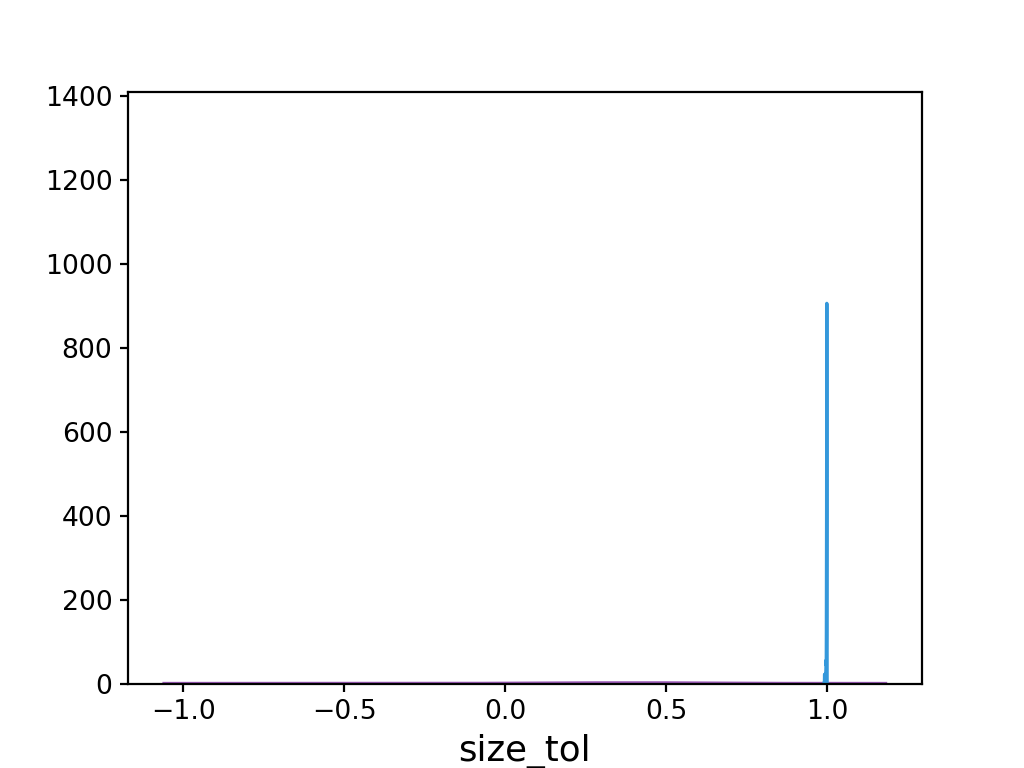

In [800]:
fig, ax = pl.subplots()
sns.distplot(ix1['size_tol'])
sns.distplot(ix2['size_tol'])

<IPython.core.display.Javascript object>


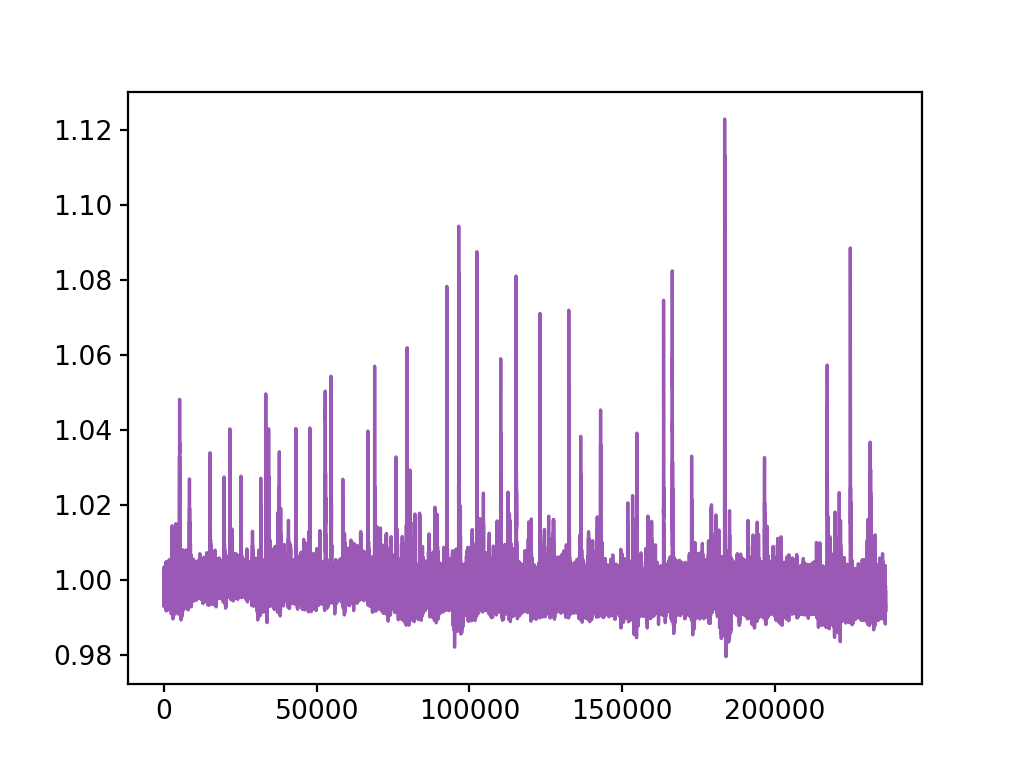

In [773]:
pl.figure()
pl.plot(traces[23])

<IPython.core.display.Javascript object>


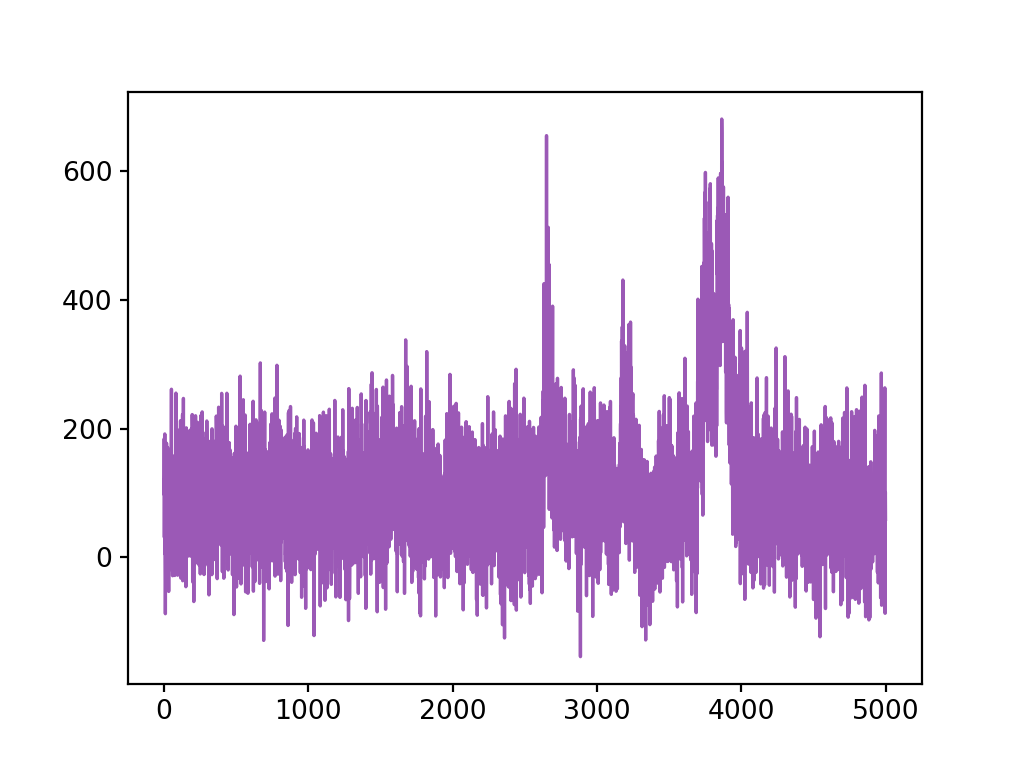

In [700]:
pl.figure()
pl.plot(dset['data'][0:5000, 23])

In [694]:
neuropil = np.load(soma_fpath.replace('np_subtracted', 'neuropil'))
neuropil['data'].min(), neuropil['data'].max()

(-120.99062049062081, 654.8007633587786)

In [689]:
neuropil['f0'].min(), neuropil['f0'].max(), neuropil['f0'].mean()

(6.560815429687501, 8030.35705180921, 376.8797332209979)

In [675]:
neuropil['data'].mean(axis=0).shape

(192,)

In [676]:
dset['data'].shape

(236250, 192)

In [646]:
test = (dset['data']-dset['f0'])/dset['f0']

In [651]:
dset['corrected'].max()

KeyError: 'corrected is not a file in the archive'

In [620]:
inputdata = pd.concat([g for (v, k), g in NDATA.groupby(['visual_area', 'datakey'])\
                     if (v, k) in unique_dkeys])

In [621]:
meanr = inputdata.groupby(['visual_area', 'datakey', 'cell', 'config']).mean().reset_index()

In [622]:
maxr = meanr.groupby(['visual_area', 'datakey', 'cell']).max().reset_index().drop(['config', 'trial'], axis=1)

In [623]:
min_quant = meanr['response'].describe()['25%']
max_quant = meanr['response'].describe()['75%']
print(min_quant, max_quant)

(532.8621775214257, 965.6301250700395)


In [426]:
maxr.head()

visual_area              datakey  cell  response
0          Li  20190315_JC070_fov1   113  0.602596
1          Li  20190315_JC070_fov1   138  0.576166
2          Li  20190315_JC070_fov1   145  0.589197
3          Li  20190315_JC070_fov1   147  0.575406
4          Li  20190315_JC070_fov1   150  0.591625

In [ ]:
curr_response_thr=0. maxr[maxr['response']>curr_response_thr]


In [490]:
passdf.head()

cell  size_tol  morph_ix  sparseness visual_area              datakey
0   174  0.950670  0.030409    0.000275          Li  20190314_JC070_fov1
1   175  0.948997  0.037606    0.000318          Li  20190314_JC070_fov1
2   177  0.933212  0.037092    0.000561          Li  20190314_JC070_fov1
3   219  0.973580  0.022953    0.000105          Li  20190314_JC070_fov1
4   220  0.975669  0.022626    0.000087          Li  20190314_JC070_fov1

<IPython.core.display.Javascript object>


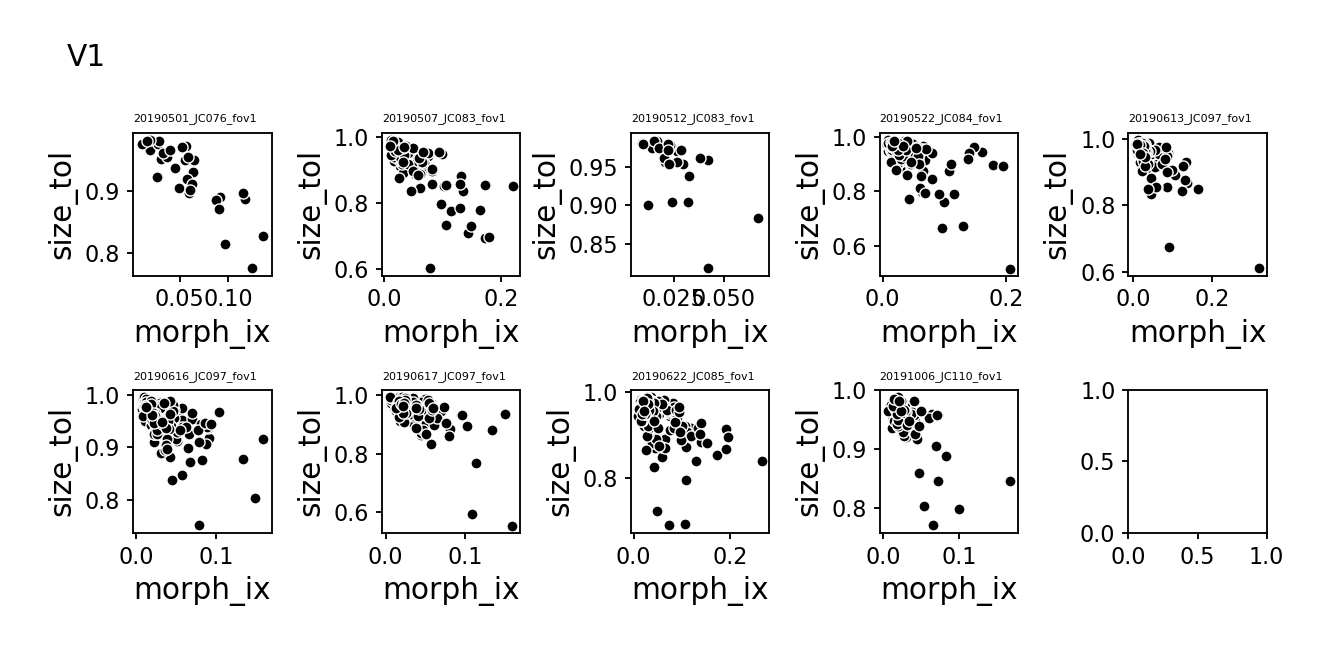

<IPython.core.display.Javascript object>


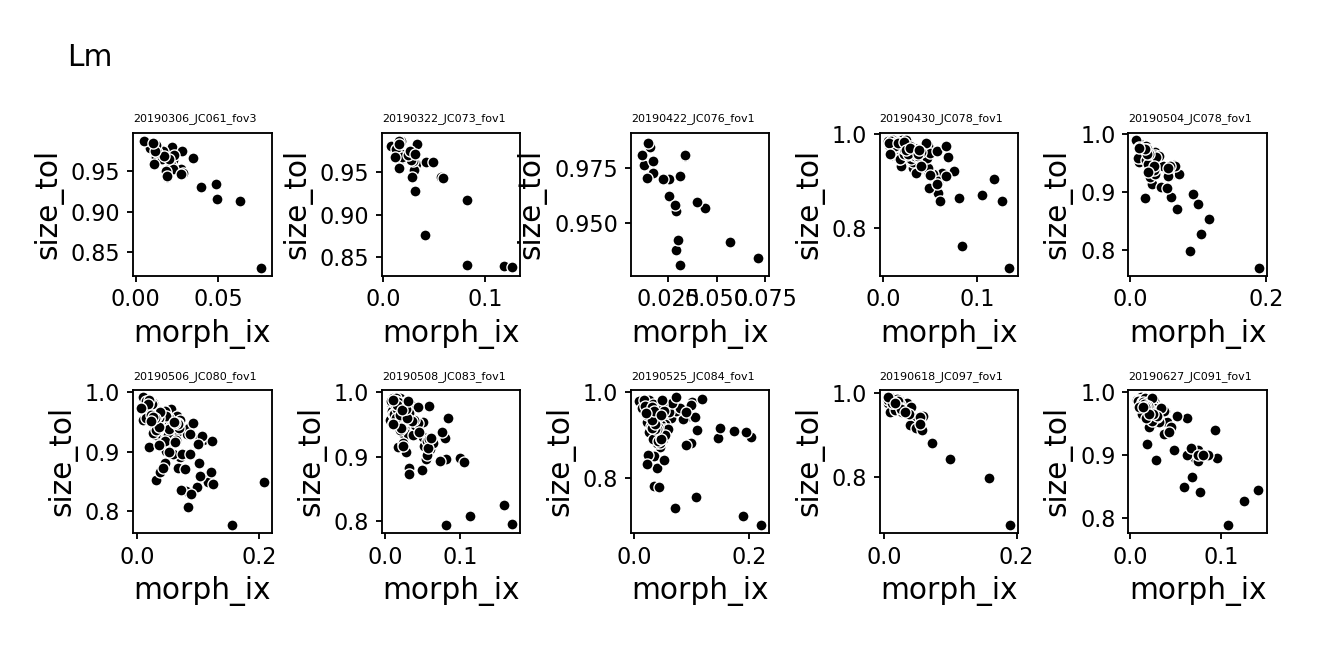

<IPython.core.display.Javascript object>


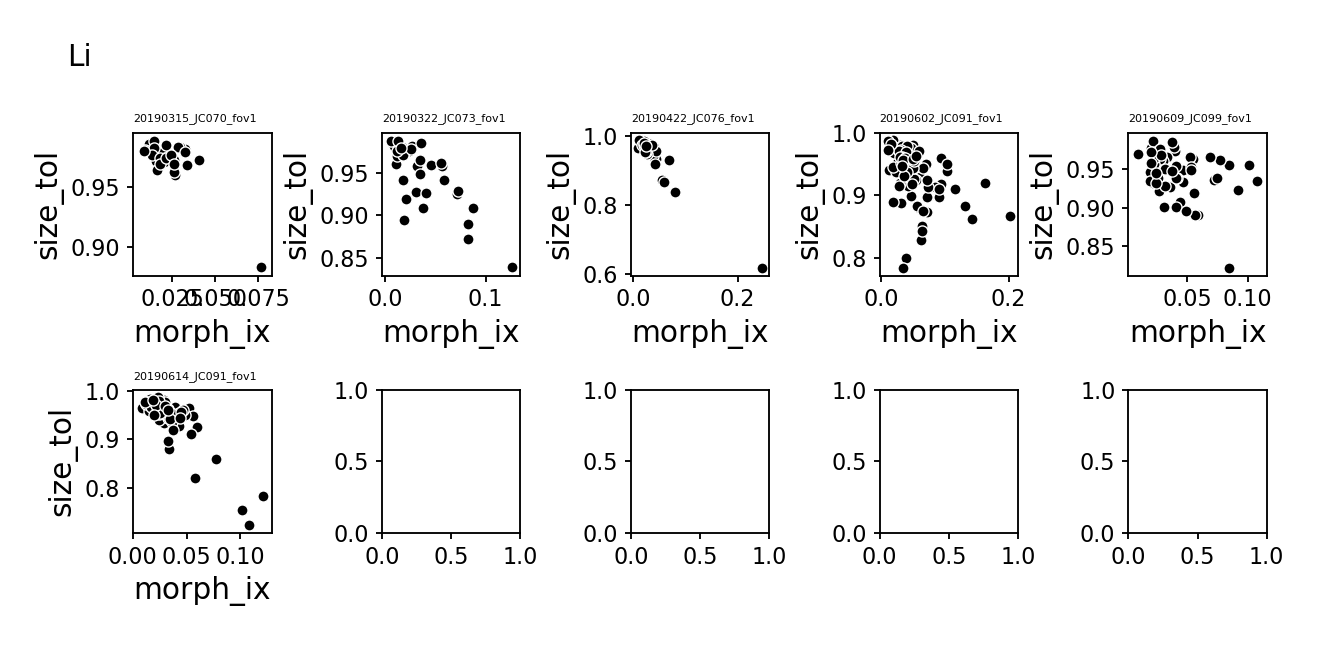

In [341]:
sel_type = 'morph_ix'


for visual_area in visual_areas:
    vg= curr_df[curr_df.visual_area==visual_area].copy()
    n_fovs = len(vg['datakey'].unique())

    fig, axn = pl.subplots(2, 5, figsize=(10, 5), sharex=False, sharey=False)
    for ax, (dk, ixs_) in zip(axn.flat, vg.groupby(['datakey'])):

        pearsons_r, pearsons_p = spstats.pearsonr(ixs_[sel_type], ixs_['size_tol'])
        #sns.regplot(x=sel_type, y='size_tol', data=ixs_, ax=ax, color='k', marker='.')
        sns.scatterplot(x=sel_type, y='size_tol', data=ixs_, ax=ax, color='k', marker='o')
        ax.set_title(dk, loc='left', fontsize=6)
        #ax.set_aspect('equal')
    pl.subplots_adjust(left=0.1, right=0.95, bottom=0.2, top=0.8, wspace=0.8, hspace=0.8)
    # ax.set_xlim([-0.05, 0.05])
    # ax.set_ylim([-0.2, 0.8])

    fig.text(0.05, 0.9, visual_area, fontsize=16)


In [ ]:
c_=[]
for (va, dk), ixs_ in passdf_drop.groupby(['visual_area', 'datakey']):
    for sel_type in ['morph_ix', 'sparseness']:
        pearsons_r, pearsons_p = spstats.pearsonr(ixs_['size_tol'], ixs_[sel_type])

# size

In [913]:
if NDATA['response'].min() < 0:
    NDATA['response'] = NDATA['response'] - NDATA['response'].min()
print(NDATA['response'].min())

0.0


In [914]:
visual_area = 'V1'
datakey = '20191006_JC110_fov1'

x0 = NDATA[(NDATA.visual_area==visual_area) & (NDATA.datakey==datakey)].copy()
sdf = SDF[datakey].copy() #aggr.get_master_sdf()

x0.head()


visual_area              datakey     config  trial cell  response
0          V1  20191006_JC110_fov1  config012      1    4  0.579568
1          V1  20191006_JC110_fov1  config041      2    4  0.650755
2          V1  20191006_JC110_fov1  config024      3    4  0.607950
3          V1  20191006_JC110_fov1  config016      4    4  0.647592
4          V1  20191006_JC110_fov1  config049      5    4  0.606354

In [778]:
# x0 = NDATA[(NDATA.visual_area==visual_area) & (NDATA.datakey==datakey)].copy()
m = x0.groupby(['cell', 'config']).mean().reset_index()

n2 = aggr.stacked_neuraldf_to_unstacked(m)
n2.shape
n3 = n2.drop('config', axis=1).divide(n2.drop('config', axis=1).sum(axis=0), axis=1)
n3['config'] = n2['config'].values
ndf = aggr.unstacked_neuraldf_to_stacked(n3)


In [779]:
test_configs = sdf[sdf['morphlevel']!=-1].index.tolist()
x=ndf.copy()
x['size'] = [sdf['size'][c] for c in ndf['config']]

std_sz = x[x.config.isin(test_configs)].groupby(['size', 'cell']).std().reset_index().drop('trial', axis=1)
piv_sz = std_sz.pivot(columns='size', index='cell')

x=ndf.copy()
x['morphlevel'] = [sdf['morphlevel'][c] for c in ndf['config']]

std_mp = x[x.config.isin(test_configs)].groupby(['morphlevel', 'cell']).std().reset_index().drop('trial', axis=1)
piv_mp = std_mp.pivot(columns='morphlevel', index='cell')



In [266]:
cell_ixs_sz, sz_ixs = np.where(piv_sz==piv_sz.max(axis=0))
#print(cell_ixs, sz_ixs)
print(piv_sz.iloc[cell_ixs_sz]*1000)

      response                                        
size      10.0      20.0      30.0      40.0      50.0
cell                                                  
57    0.686300  0.484187  0.690251  0.404962  0.227072
131   0.059209  0.124222  0.335106  0.448576  0.590107
167   0.517154  0.494219  0.307430  0.588709  0.568862
240   0.693259  0.484457  0.391094  0.428619  0.297965
257   0.293139  0.723026  0.462449  0.382076  0.244552


In [267]:
cell_ixs_mp, mp_ixs = np.where(piv_mp==piv_mp.max(axis=0))
print(piv_mp.iloc[cell_ixs_mp]*1000)

            response                                                    \
morphlevel       0         14        27        40        53        66    
cell                                                                     
131         1.802374  1.671866  1.785270  1.719807  1.428616  1.222675   
131         1.802374  1.671866  1.785270  1.719807  1.428616  1.222675   
131         1.802374  1.671866  1.785270  1.719807  1.428616  1.222675   
131         1.802374  1.671866  1.785270  1.719807  1.428616  1.222675   
131         1.802374  1.671866  1.785270  1.719807  1.428616  1.222675   
131         1.802374  1.671866  1.785270  1.719807  1.428616  1.222675   
131         1.802374  1.671866  1.785270  1.719807  1.428616  1.222675   
131         1.802374  1.671866  1.785270  1.719807  1.428616  1.222675   
240         0.914875  0.743899  0.950807  1.012272  1.192339  1.042798   

                                          
morphlevel       79        92        106  
cell                     

<IPython.core.display.Javascript object>


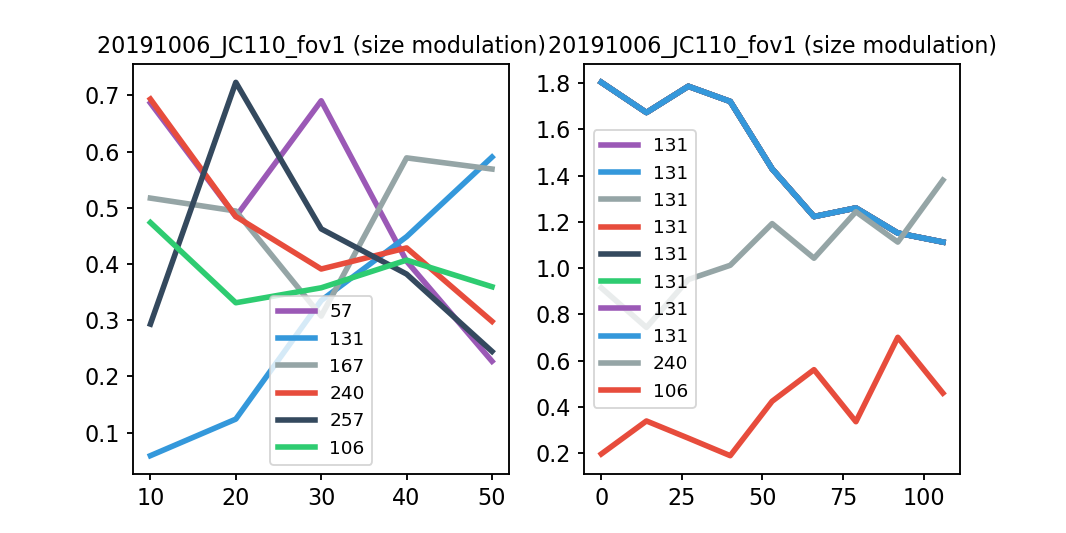

Text(0.5,1,u'20191006_JC110_fov1 (size modulation)')

In [270]:

lw=3
fig, axn= pl.subplots(1, 2, figsize=(8,4))
ax=axn[0]
for i in cell_ixs_sz:
    ax.plot(piv_sz.iloc[i]['response']*1000, label=piv_sz.iloc[i].name, lw=lw)
ax.plot(piv_sz.loc[106]['response']*1000, label=106, lw=lw)

ax.legend()
ax.set_title('%s (size modulation)' % datakey)


ax=axn[1]
for i in cell_ixs_mp:
    ax.plot(piv_mp.iloc[i]['response']*1000, label=piv_mp.iloc[i].name, lw=lw)
ax.plot(piv_mp.loc[106]['response']*1000, label=106, lw=lw)

ax.legend()
ax.set_title('%s (size modulation)' % datakey)

<IPython.core.display.Javascript object>


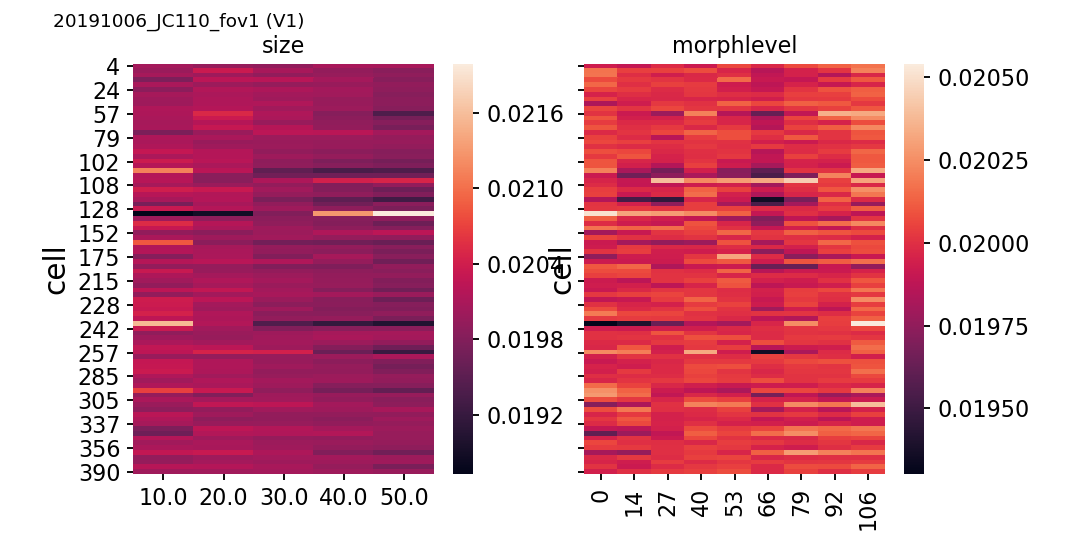

Text(0.05,0.95,u'20191006_JC110_fov1 (V1)')

In [275]:
sz_df = pd.concat([pd.Series(ndf[ndf.config.isin(sg.index.tolist())].groupby(['cell']).mean()['response'], name=sz)\
            for sz, sg in sdf[sdf.morphlevel!=-1].groupby(['size'])], axis=1)

mp_df = pd.concat([pd.Series(ndf[ndf.config.isin(sg.index.tolist())].groupby(['cell']).mean()['response'], name=sz)\
            for sz, sg in sdf[sdf.morphlevel!=-1].groupby(['morphlevel'])], axis=1)

fig, axn = pl.subplots(1,2, figsize=(8,4), sharey=True)
sns.heatmap(sz_df, ax=axn[0])
axn[0].set_title('size')

sns.heatmap(mp_df, ax=axn[1])
axn[1].set_title('morphlevel')

fig.text(0.05, 0.95, '%s (%s)' % (datakey, visual_area))

In [279]:
(5-(4./1))/(5-1)


0.25

# Morph selectivity

In [19]:
rdf = x0.groupby(['cell', 'config']).mean().reset_index().drop('trial', axis=1)
rdf['size'] = [sdf['size'][c] for c in rdf['config']]
rdf['morphlevel'] = [sdf['morphlevel'][c] for c in rdf['config']]
rdf = rdf[rdf['morphlevel']!=-1]

In [782]:
#### Generate morph tuning curves
morph_curves = rdf.groupby(['cell']).apply(get_x_curves_at_best_y, 
                                           x='morphlevel', y='size', normalize=True).reset_index(drop=True)
morph_mat = morph_curves[['cell', 'response', 'morphlevel']].pivot(columns='cell', index='morphlevel')

print(morph_curves['size'].unique())


In [784]:
#### Calculate morph selectivity index
morph_ixs = rdf.groupby(['cell']).apply(assign_morph_ix, at_best_other=True).rename(columns={0:'morph_ix'})
sorted_morph_ixs = morph_ixs.sort_values(by='morph_ix', ascending=False)
print("Top 5:")
print(sorted_morph_ixs.iloc[0:5])
print("Bottom 5:")
print(sorted_morph_ixs.iloc[-5:])

Top 5:
      morph_ix
cell          
57    0.167629
240   0.100327
257   0.083092
133   0.072142
302   0.071970
Bottom 5:
      morph_ix
cell          
38    0.009972
285   0.009716
267   0.009322
153   0.008486
325   0.005947


In [785]:
#### Generate size tuning curves
size_curves = rdf.groupby(['cell']).apply(get_x_curves_at_best_y, 
                                           x='size', y='morphlevel', normalize=True).reset_index(drop=True)
size_mat = size_curves[['cell', 'response', 'size']].pivot(columns='cell', index='size')

In [787]:
#### Calculate size tolerance
size_tols = rdf.groupby(['cell']).apply(assign_size_tolerance, at_best_other=True).rename(columns={0:'size_tol'})
sorted_size_tols = size_tols.sort_values(by='size_tol', ascending=False)
print("Top 5:")
print(sorted_size_tols.iloc[0:5])
print("Bottom 5:")
print(sorted_size_tols.iloc[-5:])

Top 5:
      size_tol
cell          
355   0.988202
380   0.985668
390   0.982500
305   0.982484
4     0.982325
Bottom 5:
      size_tol
cell          
302   0.845798
57    0.844817
167   0.802672
240   0.797823
131   0.770452


In [ ]:
#### Calculate sparseness
sparse_ixs = rdf[['cell', 'response']].groupby(['cell']).apply(assign_sparseness).rename(columns={0:'sparseness'})

In [874]:
#### Aggregate
ixs_ = pd.concat([size_tols, morph_ixs, sparse_ixs], axis=1).reset_index()
ixs_.index=ixs_['cell']
ixs_.head()

cell  size_tol  morph_ix  sparseness
cell                                      
4        4  0.982325  0.040998    0.000290
5        5  0.963247  0.015003    0.000516
6        6  0.947806  0.042051    0.000307
11      11  0.942069  0.036501    0.000697
12      12  0.973949  0.022054    0.000167

<IPython.core.display.Javascript object>


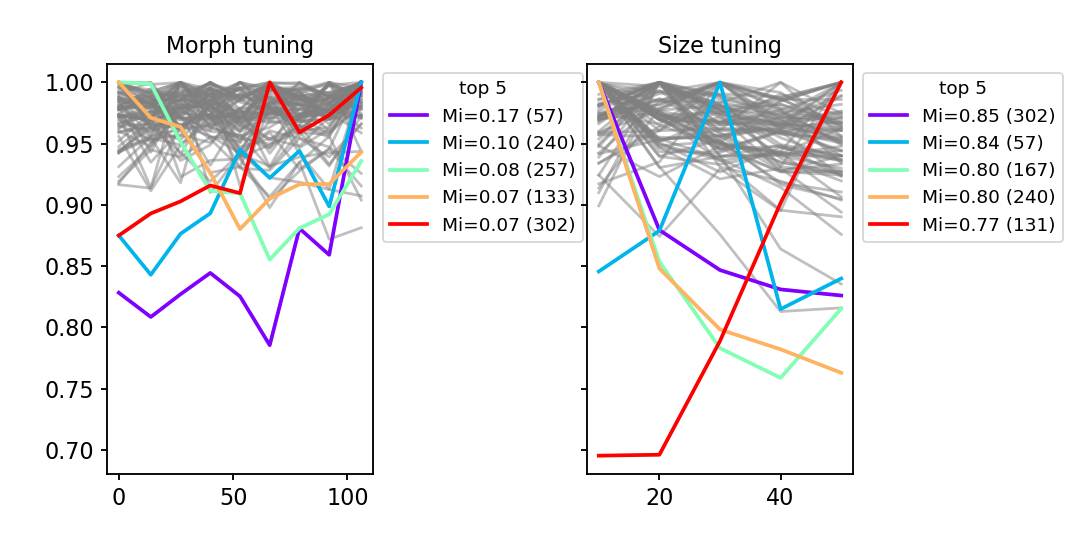

In [875]:
#### plot topntopn=5
roi_colors = pl.cm.rainbow(np.linspace(0, 1, topn))

fig, axn = pl.subplots(1,2, figsize=(8,4), sharey=True)

ax=axn[0]
ax.plot(morph_mat, color='gray', alpha=0.5)
ax.set_title("Morph tuning")
rois_plot_mp = sorted_morph_ixs.iloc[0:topn].index.tolist()
for col, rid in zip(roi_colors, rois_plot_mp):
    ax.plot(morph_mat['response', rid], color=col, lw=2, 
                label='Mi=%.2f (%i)' % (morph_ixs.loc[rid]['morph_ix'], rid))
ax.legend(title='top 5', bbox_to_anchor=(1, 1), loc='upper left')

ax=axn[1]
ax.plot(size_mat, color='gray', alpha=0.5)
ax.set_title("Size tuning")
rois_plot_sz = sorted_size_tols.iloc[-topn:].index.tolist()

for col, rid in zip(roi_colors, rois_plot_sz):
    ax.plot(size_mat['response', rid], color=col, lw=2, 
            label='Mi=%.2f (%i)' % (size_tols.loc[rid]['size_tol'], rid))
ax.legend(title='top 5', bbox_to_anchor=(1, 1), loc='upper left')

pl.subplots_adjust(wspace=0.8, left=0.1, right=0.8)

In [ ]:
#### Compare morph selectivity vs. size tolerance:

<IPython.core.display.Javascript object>


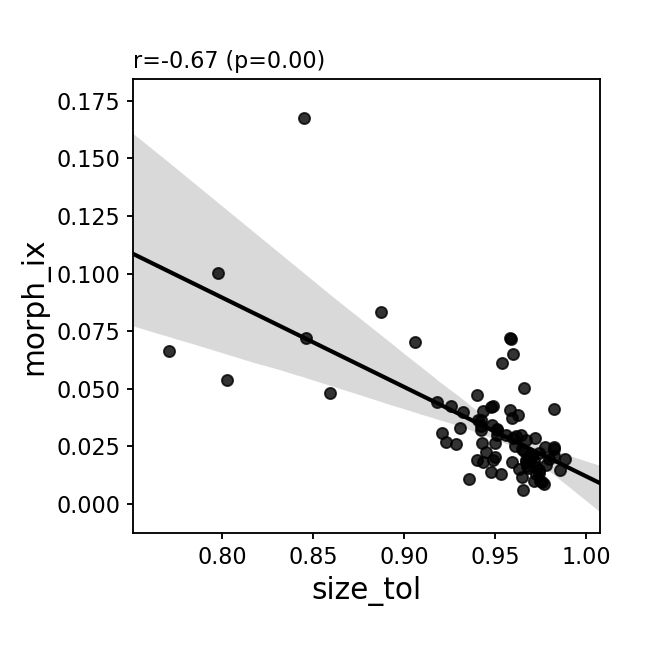

In [936]:
fig, ax = pl.subplots(figsize=(5,5))
sns.regplot(x='size_tol', y='morph_ix', data=ixs_, ax=ax, color='k')
pearsons_r, pearsons_p = spstats.pearsonr(ixs_['size_tol'], ixs_['morph_ix'])
ax.set_title("r=%.2f (p=%.2f)" % (pearsons_r, pearsons_p), loc='left')
pl.subplots_adjust(left=0.2, bottom=0.2)

In [696]:
print(rois_plot_mp)
print(rois_plot_sz)
rois_plot = np.union1d(rois_plot_mp, rois_plot_sz)


[57, 240, 257, 133, 302]
[302, 57, 167, 240, 131]


In [697]:
vmin = rdf[rdf.cell.isin(rois_plot)]['response'].min()
vmax = rdf[rdf.cell.isin(rois_plot)]['response'].max()
print(vmin, vmax)

(0.52002490646568, 0.7902469373691154)


<IPython.core.display.Javascript object>


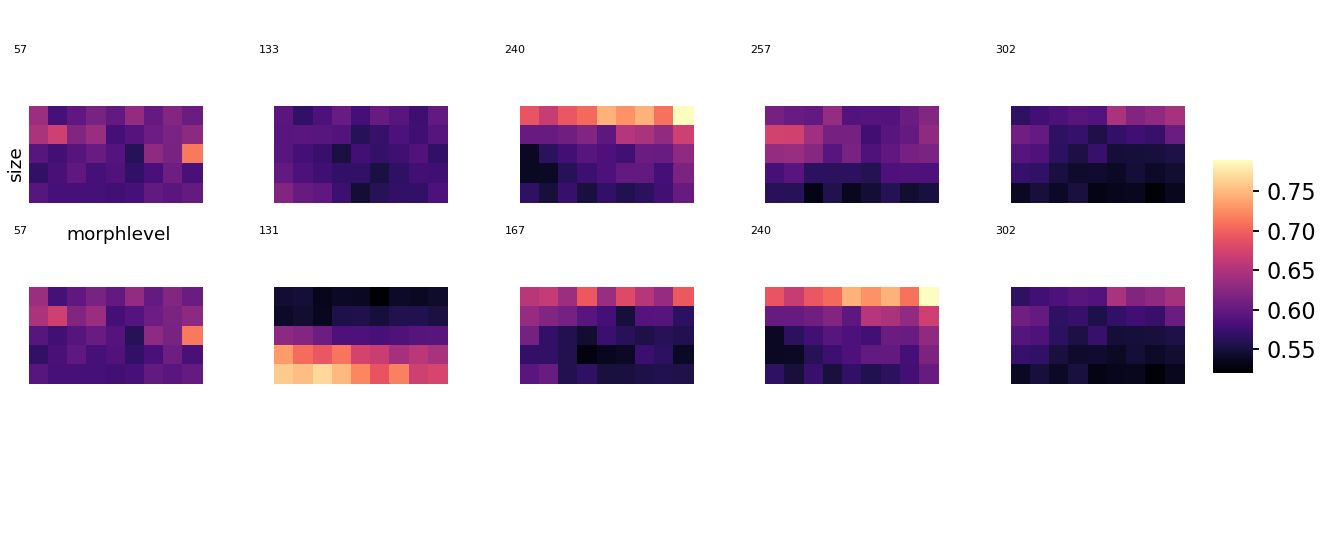

In [718]:
cmap='magma'
fig, axn = pl.subplots(2, topn, sharex=True, sharey=True, figsize=(10,4))
cbar_ax = fig.add_axes([.91, .3, .03, .4])

for ri, (roi, rd) in enumerate(rdf[rdf.cell.isin(rois_plot_mp)].groupby(['cell'])):
    ax=axn[0, ri]
    sns.heatmap(rd['response'].reshape(9,5).T, ax=ax,
                vmin=vmin, vmax=vmax, cmap=cmap, cbar=ri==0, cbar_ax=None if ri else cbar_ax)
    ax.set_aspect('equal')
    ax.set_title(roi, fontsize=6, loc='left')
    ax.axis('off')
fig.text(0.005, 0.7, 'size', rotation=90)
fig.text(0.05, 0.55, 'morphlevel', rotation=0)

for ri, (roi, rd) in enumerate(rdf[rdf.cell.isin(rois_plot_sz)].groupby(['cell'])):
    ax=axn[1, ri]
    sns.heatmap(rd['response'].reshape(9,5).T, ax=ax,
                vmin=vmin, vmax=vmax, cmap=cmap, cbar=ri==0, cbar_ax=None if ri else cbar_ax)
    ax.set_aspect('equal')
    ax.set_title(roi, fontsize=6, loc='left')
    ax.axis('off')
    
pl.subplots_adjust(left=0.01, right=0.9, bottom=0.2, hspace=0.0)

### Sekect best examples

In [726]:
rdf[rdf['response']>=0.65]['cell'].unique()

array([ 57, 104, 107, 131, 167, 240, 257])

<IPython.core.display.Javascript object>


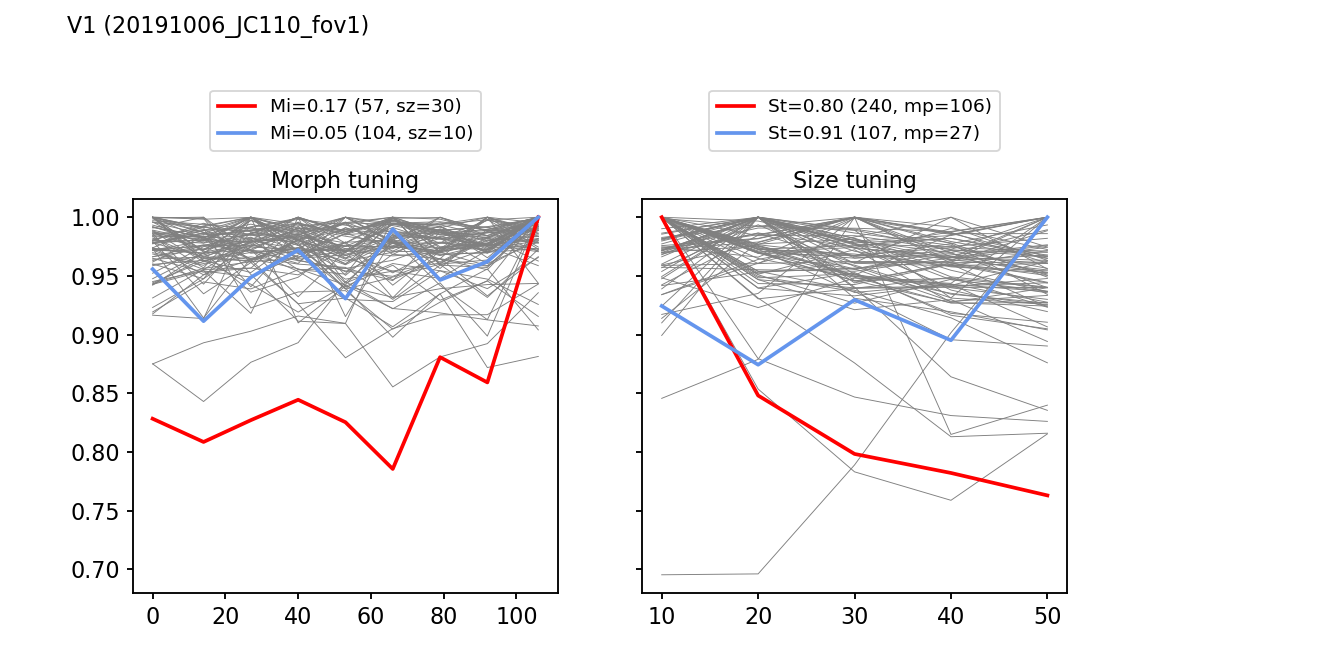

In [877]:
roi_labels = ['high', 'low'] # 'all']
roi_colors = ['red',  'cornflowerblue'] #, 'k']

fig, axn = pl.subplots(1,2, figsize=(10,5), sharey=True)

ax=axn[0]
ax.plot(morph_mat, color='gray', alpha=1, lw=0.5)
ax.set_title("Morph tuning")
rois_plot_mp = [57, 104] #, 107] #131] #104] #sorted_morph_ixs.iloc[0:topn].index.tolist()
for col, rid in zip(roi_colors, rois_plot_mp):
    best_sz = int(morph_curves[morph_curves['cell']==rid]['size'].unique())
    ax.plot(morph_mat['response', rid], color=col, lw=2, 
                label='Mi=%.2f (%i, sz=%i)' % (morph_ixs.loc[rid]['morph_ix'], rid, best_sz))
ax.legend( bbox_to_anchor=(0.5, 1.1), loc='lower center')

ax=axn[1]
ax.plot(size_mat, color='gray', alpha=1, lw=0.5)
ax.set_title("Size tuning")
rois_plot_sz = [240, 107] #, 107] #107] #sorted_size_tols.iloc[0:topn].index.tolist()

for col, rid in zip(roi_colors, rois_plot_sz):
    best_mp = int(size_curves[size_curves['cell']==rid]['morphlevel'].unique())

    ax.plot(size_mat['response', rid], color=col, lw=2, 
                label='St=%.2f (%i, mp=%i)' % (size_tols.loc[rid]['size_tol'], rid, best_mp))
ax.legend(bbox_to_anchor=(0.5, 1.1), loc='lower center')
fig.text(0.05, 0.95, '%s (%s)' % (visual_area, datakey), fontsize=12)

pl.subplots_adjust(wspace=0.2, left=0.1, right=0.8, top=0.7)

In [845]:
int(size_curves[size_curves['cell']==rid]['morphlevel'].unique())


27.0

In [647]:
rdf['response'].max()

0.7902469373691154

(0.5027450171082631, 0.6952031131698545)


IndexError: too many indices for array

In [609]:
rd['response'].reshape(9,5), 

array([[0.56981777, 0.57364562, 0.57375215, 0.55965782, 0.56425996],
       [0.57422147, 0.57669009, 0.57923581, 0.56084349, 0.57725106],
       [0.57410796, 0.58175806, 0.5784192 , 0.57808927, 0.5642958 ],
       [0.57542556, 0.57528589, 0.5706843 , 0.57750307, 0.57349688],
       [0.57701489, 0.58601119, 0.5711773 , 0.57715875, 0.56912394],
       [0.57754534, 0.56815715, 0.57131692, 0.58317837, 0.5616384 ],
       [0.57111548, 0.57836632, 0.58707754, 0.57886591, 0.57886694],
       [0.57311267, 0.57492115, 0.57766264, 0.5637506 , 0.56955009],
       [0.56571723, 0.57896397, 0.57751257, 0.57485   , 0.56766112]])

<IPython.core.display.Javascript object>


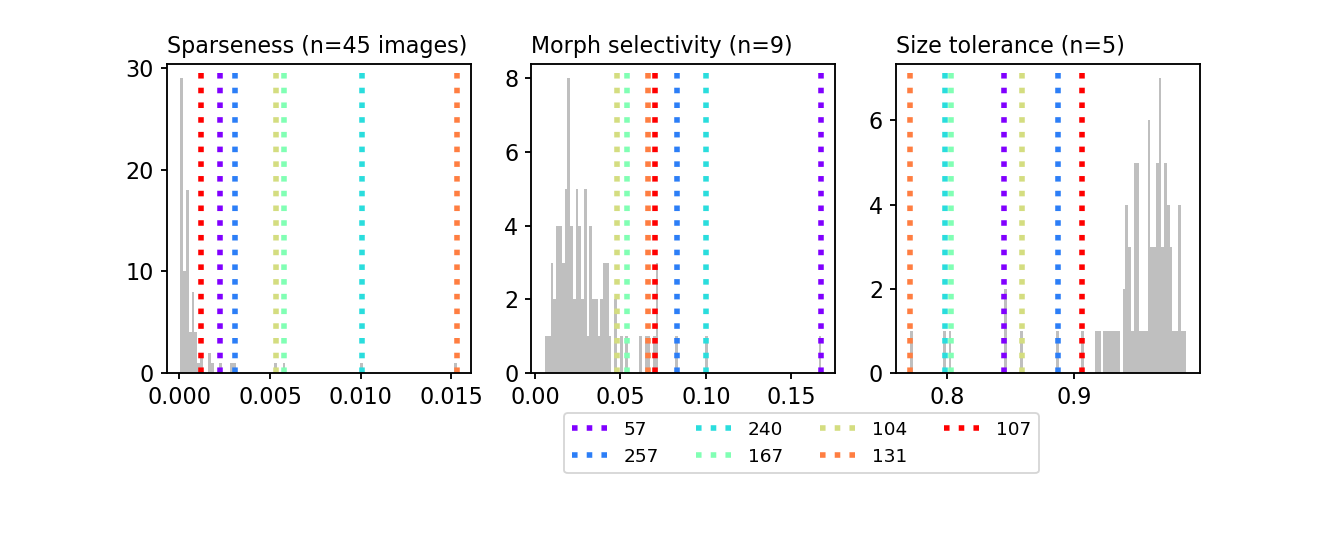

In [889]:


n_images = len(rdf['config'].unique())
n_morphs = len(np.unique([sdf['morphlevel'][c] for c in rdf['config'].unique()]))
n_sizes = len(np.unique([sdf['size'][c] for c in rdf['config'].unique()]))


rois_plot = [57, 257, 240, 167, 104, 131, 107]
color=pl.cm.rainbow(np.linspace(0, 1, len(rois_plot)))

fig, axn = pl.subplots(1,3, figsize=(10,4))

#### Sparsensess
ax=axn[0]
ax.hist(ixs_['sparseness'].values, bins=100, color='gray', alpha=0.5)
for r, c in zip(rois_plot, color):
    ax.axvline(ixs_['sparseness'].loc[r], color=c, label=r, linestyle=':', lw=3)
ax.set_title('Sparseness (n=%i images)' % n_images, loc='left')

#### Morph selectivity
ax=axn[1]
ax.hist(ixs_['morph_ix'].values, bins=100, color='gray', alpha=0.5)
for r, c in zip(rois_plot, color):
    ax.axvline(ixs_['morph_ix'].loc[r], color=c, label=r, linestyle=':', lw=3)
ax.set_title('Morph selectivity (n=%i)' % n_morphs, loc='left')

#### Size tuning
ax=axn[2]
ax.hist(ixs_['size_tol'].values, bins=100, color='gray', alpha=0.5)
for r, c in zip(rois_plot, color):
    ax.axvline(ixs_['size_tol'].loc[r], color=c, label=r, linestyle=':', lw=3)
ax.set_title('Size tolerance (n=%i)' % n_sizes, loc='left')

ax.legend(bbox_to_anchor=(0.5, -0.1), ncol=4)
pl.subplots_adjust(bottom=0.3)



In [883]:
ixs_['size_tol']

cell
4      0.982325
5      0.963247
6      0.947806
11     0.942069
12     0.973949
24     0.959558
33     0.977246
38     0.971439
46     0.968502
55     0.968547
57     0.844817
61     0.951170
65     0.943397
76     0.948799
77     0.950042
79     0.957870
85     0.974221
86     0.972298
100    0.950989
101    0.977810
102    0.953107
103    0.944793
104    0.858944
106    0.932196
107    0.905845
108    0.956141
112    0.942284
116    0.949694
118    0.918031
121    0.959964
         ...   
243    0.979516
248    0.970308
252    0.982175
255    0.925457
257    0.887450
267    0.975909
275    0.948866
276    0.941952
279    0.964935
285    0.974794
298    0.971071
301    0.969143
302    0.845798
304    0.958465
305    0.982484
307    0.963955
310    0.965554
325    0.965214
336    0.968281
337    0.967287
338    0.940227
353    0.961225
354    0.959225
355    0.988202
356    0.966682
364    0.948350
375    0.973809
380    0.985668
383    0.964546
390    0.982500
Name: size_tol, Len

In [884]:
r

107

In [ ]:
filter_by='most_fits'
blob_dsets = aggr.get_blob_datasets(filter_by=filter_by, as_dict=False, response_type=response_type,
                                    responsive_test=responsive_test, responsive_thr=responsive_thr)

all_dkeys = sdata[(sdata['experiment']==experiment)]['datakey'].unique()
unique_dkeys = blob_dsets['datakey'].unique()

n_drop = len(all_dkeys) - len(unique_dkeys)
print("Dropping %i dkeys (%i of %i dkeys unique)" % (n_drop, len(unique_dkeys), len(all_dkeys)))